In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python import utils as putils

from pipeline.python.classifications import decode_by_ncells as dc
from pipeline.python.classifications import decode_utils as decutils
from pipeline.python.retinotopy import fit_2d_rfs as fitrf

from matplotlib.lines import Line2D
import matplotlib.patches as patches

In [2]:
%matplotlib notebook

In [3]:
# Set colors
visual_areas, area_colors = putils.set_threecolor_palette(soft=True)
dpi = putils.set_plot_params()


# Dataset info

In [4]:
analysis_type='split_pupil'

responsive_test='ROC'
responsive_thr=10. if responsive_test=='nstds' else 0.05
trial_epoch='plushalf'

experiment='blobs'
C_value=None
n_iterations=100
overlap_thr=None #0.5
n_processes=1

options=['-E', experiment, '-R', responsive_test, '-r', responsive_thr, '-n', n_processes, '-N', n_iterations, 
         '-o', overlap_thr, '-C', C_value, '-X', analysis_type, '--epoch=%s' % trial_epoch]

In [5]:
#### Extract options
opts = dc.extract_options(options)
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir = opts.rootdir
create_new = opts.create_new
verbose=opts.verbose

# Pick dataset ------------------------------------ 
traceid = opts.traceid #'traces001'
response_type = opts.response_type #'dff'
responsive_test = opts.responsive_test #'nstds' # 'nstds' #'ROC' #None
if responsive_test=='None':
    responsive_test=None
responsive_thr = float(opts.responsive_thr) if responsive_test is not None else 0.05 #10

# Classifier info ---------------------------------
experiment = opts.experiment #'blobs'
class_a=int(opts.class_a) #0
class_b=int(opts.class_b) #106
n_iterations=int(opts.n_iterations) #100 
n_processes=int(opts.n_processes) #2
trial_epoch = opts.trial_epoch

analysis_type=opts.analysis_type

# CV ----------------------------------------------
test_split=0.2
cv_nfolds=5
C_value=opts.C_value
do_cv = C_value is None
m0=0
m100=106
print('Classify Morph %i v %i\nN=%i iterations (%i proc), overlap=%s, C=%s' \
      % (m0, m100, n_iterations, n_processes, str(overlap_thr), str(C_value)))

# Dataset filtering --------------------------------
filter_fovs = True
remove_too_few = True
min_ncells = 10 if remove_too_few else 0
overlap_thr = None if opts.overlap_thr in ['None', None] else float(opts.overlap_thr)
has_rfs = overlap_thr is not None

stim_filterby = None # 'first'
has_gratings = experiment!='blobs'
g_str = 'hasgratings' if has_gratings else 'blobsonly'

# Create data ID for labeling figures with data-types
response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 
stimfilter_str = 'filter_%s_%s' % (stim_filterby, g_str)
data_id = '|'.join([traceid, stimfilter_str, response_str])
print(data_id)


match_distns = opts.match_distns
if analysis_type=='single_cells':
    match_distns = False
match_str = 'matchdistns_' if match_distns else ''

# Pupil -------------------------------------------
pupil_feature='pupil_area'
pupil_alignment='trial'
pupil_epoch='pre'
pupil_snapshot=391800
redo_pupil=False
pupil_framerate=20.
# -------------------------------------------------

# Alignment 
iti_pre=1.
iti_post=1.
stim_dur=1.

# RF stuff 
rf_filter_by=None
reliable_only = True
rf_fit_thr = 0.05

Classify Morph 0 v 106
N=100 iterations (1 proc), overlap=None, C=None
traces001|filter_None_blobsonly|dff_ROC-thr-0.05


In [6]:
train_str = '%s_iter-%i' % (analysis_type, n_iterations)
print(train_str, trial_epoch)

# Set colors
visual_area, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()

('split_pupil_iter-100', 'plushalf')


# Output dir

In [7]:
#### Output dir
analysis_type = 'split_pupil'
stats_dir = os.path.join(aggregate_dir, 'data-stats')

dst_dir = os.path.join(aggregate_dir, 'decoding', analysis_type)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
    print(dst_dir)
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil


# Get metadata for experiment type

In [8]:
#### Get metadata for experiment type
print("Filtering <%s> by: %s" % (experiment, str(stim_filterby)))
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
dsets, keys_by_area = aggr.experiment_datakeys(experiment=experiment, 
                            experiment_only=False,stim_filterby=stim_filterby,
                            has_gratings=has_gratings, has_rfs=has_rfs, )
stim_datakeys = dsets['datakey'].unique()


Filtering <blobs> by: None
Segmentation: missing 9 dsets
Segmentation: missing 9 dsets
Segmentation: missing 9 dsets


# Get source (input) data

In [357]:
#responsive_test='ROC'
#responsive_thr=10. if responsive_test=='nstds' else 0.05
print("............................................")
print("Responsive test: %s (thr=%.2f)" % (responsive_test, responsive_thr))
print("............................................")

curr_visual_area=None #'V1'
curr_datakey = None# '20190617_JC097_fov1'

#### Load neural responses
stack_neuraldf = analysis_type in ['by_ncells']

#### Check for equal trial counts
visual_areas=['V1', 'Lm', 'Li', 'Ll']
_, all_cells, MEANS, SDF = aggr.get_source_data(experiment,
                        equalize_now=False, zscore_now=False,
                        response_type=response_type, responsive_test=responsive_test,
                        responsive_thr=responsive_thr, trial_epoch=trial_epoch, #use_all=False,
                        visual_area=curr_visual_area,
                        datakey=curr_datakey,
                        check_configs=True, return_configs=True, return_missing=False,
                        images_only=analysis_type=='by_ncells')

all_cells = all_cells[all_cells['visual_area'].isin(visual_areas)]
all_cells.groupby(['visual_area']).count()


............................................
Responsive test: ROC (thr=0.05)
............................................
Segmentation: missing 9 dsets
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_plushalf.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [-15   0], y: [-5  0]
(skipping 20190314_JC070_fov1)
Segmentation: missing 9 dsets
SDF, images_only=False (excluding dsetes: [])
Segmentation: missing 3 dsets


cell   fov  animalid  session  datakey  fovnum  global_ix
visual_area                                                           
Li            585   585       585      585      585     585        585
Ll             39    39        39       39       39      39         39
Lm           1127  1127      1127     1127     1127    1127       1127
V1           1251  1251      1251     1251     1251    1251       1251

# Pupil

In [239]:
from pipeline.python.eyetracker import dlc_utils as dlcutils

In [240]:
def count_pupil_n_trials_missing(pupil_train_counts):
    '''
    expects pupil_train_counts to be a dataframe of N train trials
    Old: (key=datakey, value=pupil data df)
    '''
    c_=[]
    #for datakey, pdata in pupildata.items():
    for datakey, pdata in pupil_train_counts.groupby(['datakey']):
        ntrials_t = pdata.shape[0]
        ntrials_p = pdata.dropna().shape[0]
        c_.append(pd.Series({'datakey': datakey, 'ntrials_total': ntrials_t, 'ntrials_pass': ntrials_p}))
    pupil_counts = pd.concat(c_, axis=1).T
    pupil_counts['ntrials_missing'] = pupil_counts['ntrials_total'] - pupil_counts['ntrials_pass']
    pupil_counts.index = pupil_counts['datakey']
    pupil_counts = pupil_counts.drop(['datakey'], axis=1)
    
    return pupil_counts


In [241]:
def count_pupil_training_trials(ndata, pdata, sdf, class_name='morphlevel', class_a=0, class_b=106,
                                train_transform_name=None, train_transform_value=None):
    '''
    Return subset of trials for training set or decoding subset.
    ndata: df (neural df for 1 dset)
    pdata: df (pupil df for 1 dset)
    '''
    #noncell_cols=['visual_area', 'datakey', 'config', 'trial']
    ndata['trial']=ndata.index
    assert pdata.shape[0] == ndata.shape[0], "Incorrect trial #s included"
    assert sorted(pdata['trial'].unique()) == sorted(ndata['trial'].unique()), \
            "Pupil trials are not the same as neural trials"

    # Get train configs
    #class_a=0; class_b=106;
    if train_transform_name is not None and train_transform_value is not None:
        if not isinstance(train_transform_value, (list, np.array)):
            train_transform_value = [train_transform_value]
        train_configs = sdf[sdf[class_name].isin([class_a, class_b]) &
                           sdf[train_transform_name].isin(train_transform_value)].index.tolist()
    else:
        train_configs = sdf[sdf[class_name].isin([class_a, class_b])].index.tolist()
    train_trials = sorted(ndata[ndata['config'].isin(train_configs)]['trial'].unique())

    sub_pdata = pdata[pdata['trial'].isin(train_trials)] #.dropna()
    sub_ndata = ndata[ndata['trial'].isin(train_trials)] #.dropna()
    
    return sub_ndata, sub_pdata

In [358]:
pupil_feature = 'pupil_fraction'
pupil_epoch = 'pre'
alignment_type='trial'
n_cuts=3
redo_pupil=False 

pupil_snapshot=391800
pupil_framerate=20.   
iti_pre=1.
iti_post=1.
stim_dur=1.

#if 'pupil' in analysis_type:
del pupildata
pupildata, missing_pupil = dlcutils.get_aggregate_pupildfs(experiment=experiment, feature_name=pupil_feature, 
                                        alignment_type=alignment_type, trial_epoch=pupil_epoch,
                                        iti_pre=iti_pre, iti_post=iti_post, stim_dur=stim_dur,
                                        in_rate=pupil_framerate, out_rate=pupil_framerate,
                                        snapshot=pupil_snapshot, create_new=redo_pupil, return_missing=True)
# print('20190322_JC073_fov1' in pupildata.keys())
print(missing_pupil)


>>>> Loaded aggregate pupil dataframes.
Segmentation: missing 9 dsets
['20190315_JC070_fov1']


In [347]:
pupildata['20191018_JC113_fov1'].shape, MEANS['20191018_JC113_fov1'].shape

((2350, 6), (2850, 89))

In [196]:
# pupildata = add_stimuli_to_pupildf(pupildata, MEANS, SDF)

## Aggregate pupildata into df, match to neuraldata

In [ ]:
reload(dlcutils)

In [359]:
# def get_train_configs(sdf, class_name='morphlevel', class_a=0, class_b=106,
#                                 train_transform_name=None, train_transform_value=None):

#     # Get train configs
#     if train_transform_name is not None and train_transform_value is not None:
#         if not isinstance(train_transform_value, (list, np.array)):
#             train_transform_value = [train_transform_value]
#         train_configs = sdf[sdf[class_name].isin([class_a, class_b]) &
#                            sdf[train_transform_name].isin(train_transform_value)].index.tolist()
#     else:
#         train_configs = sdf[sdf[class_name].isin([class_a, class_b])].index.tolist()
#     # train_trials = sorted(ndata[ndata['config'].isin(train_configs)]['trial'].unique())
    
#     return train_configs

    
# def add_stimuli_to_pupildf(pupildata, MEANS, SDF, verbose=False, return_valid_only=False):
#     '''
#     pupildata (dict):  keys are datakeys, values are dataframe of pupil info (all trials)
#     MEANS (dict):  keys are datakeys, cells not split by area here, just need the trial nums
#     SDF (dict): stim config dfs for each datakey
    
#     # If no match, might be some incorrect alignment 
#     '''
#     bad_alignment=[]
    
#     for datakey, pdata in pupildata.items():
#         ndata = MEANS[datakey].copy()
#         ntrials_total, ncols = ndata.shape
#         sdf = SDF[datakey].copy()
        
#         # Make sure pupil trials are same as neural trials:
#         if sorted(ndata.index.tolist())!=sorted(pdata['trial'].unique()):
#             print("ERROR: %s -- bad trial alignment? Neural trials != pupil trials." % datakey)
#             ndata, pdata = dlcutils.match_trials_df(ndata, pdata, equalize_conditions=False)
#             ntrials_dropped = ntrials_total - ndata.shape[0]
#             bad_alignment.append((datakey, ntrials_dropped))        
        
#         # Addd config info to pupildata
#         if 'trial' not in ndata.columns:
#             ndata['trial'] = ndata.index.tolist()
#         pdata['config'] = [ndata[ndata['trial']==t]['config'].unique()[0] for t in pdata['trial']]
#         train_configs = get_train_configs(sdf, class_name=class_name, class_a=class_a, class_b=class_b,
#                                     train_transform_name=train_transform_name, 
#                                     train_transform_value=train_transform_value)
#         # Get counts
#         n_train_trials = pdata[pdata.config.isin(train_configs)].shape[0]
#         n_train_trials_incl = pdata.dropna()[pdata.config.isin(train_configs)].shape[0]
#         pdata['n_train_trials'] = n_train_trials
#         pdata['n_train_trials_dropped'] = n_train_trials - n_train_trials_incl

#         # Remove neural trials that don't have valid pupil data
#         ndata, pdata = dlcutils.match_trials_df(ndata, pdata.dropna(), equalize_conditions=False)    
#         ntrials_dropped = ntrials_total - ndata.shape[0]
        
#         # Add some meta info
#         pdata['datakey'] = datakey
#         pdata['size'] = [sdf['size'][c] for c in pdata['config']]
#         pdata['morphlevel'] = [sdf['morphlevel'][c] for c in pdata['config']]
#         pdata['n_trials_total'] = ntrials_total
#         pdata['n_trials_dropped'] = ntrials_dropped
        
#         if verbose and (ntrials_total != ndata.shape[0]):
#             print('... %s: Dropping %i of %i trials' % (datakey, ntrials_dropped, ntrials_total))
            
#         if return_valid_only:
#             MEANS[datakey] = ndata
#             pupildata[datakey] = pdata
        
#     return pupildata, MEANS

In [360]:
#### Remove trials with no pupildata
pupildata, MEANS = dlcutils.add_stimuli_to_pupildf(pupildata, MEANS, SDF, verbose=False, return_valid_only=True)

ERROR: 20191018_JC113_fov1 -- bad trial alignment? Neural trials != pupil trials.


In [361]:

curr_datakey = '20190512_JC083_fov1'
pdata = pupildata[curr_datakey].copy()
ndata = MEANS[curr_datakey].copy()
print(pdata.shape, ndata.shape)

sdf = SDF[curr_datakey].copy()

((1434, 14), (1434, 113))


In [362]:
pdata

trial  frame  pupil_area  frame_int  frame_ix  pupil_fraction  \
0        1.0    9.5  593.718311        9.5       9.5        0.582607   
1        2.0    9.5  412.658117        9.5       9.5        0.404935   
2        3.0    9.5  409.877847        9.5       9.5        0.402207   
3        4.0    9.5  451.443446        9.5       9.5        0.442995   
4        5.0    9.5  348.668212        9.5       9.5        0.342143   
5        6.0    9.5  409.448883        9.5       9.5        0.401786   
6        7.0    9.5  420.315831        9.5       9.5        0.412450   
7        8.0    9.5  426.626944        9.5       9.5        0.418643   
8        9.0    9.5  407.685857        9.5       9.5        0.400056   
9       10.0    9.5  497.226439        9.5       9.5        0.487921   
10      11.0    9.5  638.496195        9.5       9.5        0.626547   
11      12.0    9.5  823.878036        9.5       9.5        0.808460   
12      13.0    9.5  390.743583        9.5       9.5        0.383431   
13      14.0    9.5  393.611840        9.5       9.5        0.386246   
14      15.0    9.5  380.187140        9.5       9.5        0.373072   
15      16.0    9.5  448.343301        9.5       9.5        0.439953   
16      17.0    9.5  439.897016        9.5       9.5        0.431665   
17      18.0    9.5  855.171180        9.5       9.5        0.839167   
18      19.0    9.5  902.513582        9.5       9.5        0.885624   
19      20.0    9.5  919.353539        9.5       9.5        0.902148   
20      21.0    9.5  557.019255        9.5       9.5        0.546595   
21      22.0    9.5  619.436850        9.5       9.5        0.607844   
22      23.0    9.5  530.985701        9.5       9.5        0.521049   
23      24.0    9.5  546.767204        9.5       9.5        0.536535   
24      25.0    9.5  661.102310        9.5       9.5        0.648730   
25      26.0    9.5  521.527843        9.5       9.5        0.511768   
26      27.0    9.5  466.482478        9.5       9.5        0.457753   
27      28.0    9.5  397.516045        9.5       9.5        0.390077   
28      29.0    9.5  369.199968        9.5       9.5        0.362291   
29      30.0    9.5  513.227536        9.5       9.5        0.503623   
...      ...    ...         ...        ...       ...             ...   
1545  1546.0    9.5  155.217024        9.5       9.5        0.152312   
1546  1547.0    9.5  183.888010        9.5       9.5        0.180447   
1547  1548.0    9.5  106.976090        9.5       9.5        0.104974   
1548  1549.0    9.5  113.192112        9.5       9.5        0.111074   
1549  1550.0    9.5  108.761822        9.5       9.5        0.106726   
1550  1551.0    9.5  224.664253        9.5       9.5        0.220460   
1551  1552.0    9.5  217.830790        9.5       9.5        0.213754   
1552  1553.0    9.5  218.035621        9.5       9.5        0.213955   
1553  1554.0    9.5  225.797702        9.5       9.5        0.221572   
1554  1555.0    9.5  239.828525        9.5       9.5        0.235340   
1555  1556.0    9.5  166.491464        9.5       9.5        0.163376   
1556  1557.0    9.5  187.498390        9.5       9.5        0.183989   
1557  1558.0    9.5  191.406127        9.5       9.5        0.187824   
1558  1559.0    9.5  158.549741        9.5       9.5        0.155583   
1559  1560.0    9.5  225.869032        9.5       9.5        0.221642   
1560  1561.0    9.5  305.035446        9.5       9.5        0.299327   
1561  1562.0    9.5  237.777082        9.5       9.5        0.233327   
1562  1563.0    9.5  225.865128        9.5       9.5        0.221638   
1563  1564.0    9.5  166.942188        9.5       9.5        0.163818   
1564  1565.0    9.5  144.750754        9.5       9.5        0.142042   
1565  1566.0    9.5  143.754007        9.5       9.5        0.141064   
1566  1567.0    9.5  124.023097        9.5       9.5        0.121702   
1567  1568.0    9.5  106.030738        9.5       9.5        0.104046   
1568  1569.0    9.5  125.780100        9.5     

In [332]:
pdata.dropna().shape, ndata.dropna().shape

((1434, 6), (1575, 112))

In [371]:
count_cols = ['datakey', 'n_trials_total', 'n_trials_dropped', 'n_train_trials', 'n_train_trials_dropped']
pupil_counts = pd.concat([pdata[count_cols].drop_duplicates().copy() \
                          for dk, pdata in pupildata.items()]).reset_index(drop=True)
pupil_counts.head()
    


datakey  n_trials_total  n_trials_dropped  n_train_trials  \
0  20190512_JC083_fov1            1575               141             314   
1  20190420_JC076_fov1            1500               243             300   
2  20190319_JC067_fov1            1350              1070             300   
3  20190603_JC080_fov1            1500                14             300   
4  20190506_JC080_fov1            1450               451             290   

   n_train_trials_dropped  
0                      29  
1                      52  
2                     238  
3                       3  
4                      91

In [311]:
#### Count training trials
#neuraldata_counts={}
# plist=[]
# for datakey, pdata in pupildata.items():
#     ndata = MEANS[datakey].copy()
#     sdf = SDF[datakey].copy()
#     try:
#         sub_ndata, sub_pdata = count_pupil_training_trials(ndata, pdata, sdf)
#     except AssertionError as e:
#         print(datakey, e)
#         continue
#     #neuraldata_counts[datakey] = sub_ndata
#     plist.append(sub_pdata)
# #neural_counts = aggr.neuraldf_dict_to_dataframe(neuraldata_counts, response_type=response_type)
# pupil_train_counts = pd.concat(plist, axis=0).reset_index(drop=True)

In [375]:
#pcounts = count_pupil_n_trials_missing(pupil_train_counts)
#pcounts['fraction_missing'] = pcounts['ntrials_missing'].divide(pcounts['ntrials_total'].astype(float))
#pcounts.head()
pupil_counts['fraction_missing_total'] = pupil_counts['n_trials_dropped']\
                                            .divide(pupil_counts['n_trials_total'].astype(float))
pupil_counts['fraction_missing'] = pupil_counts['n_train_trials_dropped']\
                                            .divide(pupil_counts['n_train_trials'].astype(float))

In [376]:
pupil_counts

datakey  n_trials_total  n_trials_dropped  n_train_trials  \
0   20190512_JC083_fov1            1575               141             314   
1   20190420_JC076_fov1            1500               243             300   
2   20190319_JC067_fov1            1350              1070             300   
3   20190603_JC080_fov1            1500                14             300   
4   20190506_JC080_fov1            1450               451             290   
5   20190510_JC083_fov1            1750               959             350   
6   20190316_JC070_fov1            1350                 0             300   
7   20190614_JC091_fov1            1500                28             300   
8   20190422_JC076_fov1            1500                 5             300   
9   20190517_JC083_fov1            1250                12             250   
10  20190613_JC097_fov1            1500               126             300   
11  20191018_JC113_fov1            2850               503             470   
12  20191111_JC120_fov1            1500                11             300   
13  20190622_JC085_fov1            1500               585             300   
14  20190501_JC076_fov1            1500               501             300   
15  20190314_JC070_fov1            1350               174             300   
16  20190504_JC078_fov1            1500                 1             300   
17  20190617_JC099_fov1             973                 3             195   
18  20190606_JC091_fov1            1625               823             325   
19  20190327_JC073_fov1            1500                 1             600   
20  20190618_JC097_fov1            1500                16             300   
21  20190602_JC091_fov1            1499               814             299   
22  20190321_JC070_fov1            1125               226             250   
23  20190616_JC097_fov1            1500                 4             300   
24  20190508_JC083_fov1            1465                46             293   
25  20190612_JC099_fov1            1500                 1             300   
26  20190306_JC061_fov3            1350               147             300   
27  20190320_JC067_fov1            1350               695             300   
28  20190507_JC083_fov1            1500                17             300   
29  20190617_JC097_fov1            1475               526             294   
30  20190511_JC083_fov1            1500                 7             300   
31  20190509_JC078_fov1            1500                 1             300   
32  20190430_JC078_fov1            1475                 1             294   
33  20191006_JC110_fov1            1675                 1             337   
34  20190525_JC084_fov1            1500                 0             300   
35  20190607_JC091_fov1            1500               458             300   
36  20190522_JC084_fov1            1500                33             300   
37  20190322_JC073_fov1            1350                72             300   
38  20190609_JC099_fov1            1500                77             300   
39  20190627_JC091_fov1            1500                46             300   
40  20190513_JC078_fov1            1475                 0             294   

    n_train_trials_dropped  fraction_missing_total  fraction_missing  
0                       29                0.089524          0.092357  
1                       52                0.162000          0.173333  
2                      238                0.792593          0.793333  
3                        3                0.009333          0.010000  
4                       91                0.311034          0.313793  
5                      191                0.548000          0.545714  
6                        0                0.000000          0.000000  
7                        5                0.018667          0.016667  
8                        0                0.003333          0.000000  
9                        3                0.009600          0.012000  


In [379]:
remove_too_few=False
min_ncells=5
has_retino=False
threshold_snr=False
threshold_dff=False

if analysis_type in ['single_cells', 'by_fov', 'split_pupil']:
    match_distns = False
match_str = 'matchdistns_' if match_distns else ''
if threshold_dff:
    overlap_str = 'threshdff'
else:
    if has_retino:
        overlap_str = 'retino'
    else:
        overlap_str = 'noRF' if overlap_thr is None else 'overlap%.1f' % overlap_thr

NEURALDATA, CELLS = dc.get_cells_and_data(all_cells, MEANS, traceid=traceid, response_type=response_type, 
                            stack_neuraldf=stack_neuraldf, overlap_thr=overlap_thr, 
                            has_retino=has_retino, threshold_snr=threshold_snr, 
                            remove_too_few=remove_too_few, min_ncells=min_ncells) 
                                
print("------------------------------------")
print("Final cell counts:")
CELLS[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()

cell_counts = dict(CELLS.groupby(['visual_area'])['cell'].count())

print("@@@@@@@@ cell counts @@@@@@@@@@@")
print(cell_counts)


Segmentation: missing 9 dsets
Segmentation: missing 9 dsets
~~~~~~~~~~~~~~~~No Receptive Fields~~~~~~~~~~~~~~~~~~~~~~~~~
Assigned visual areas: [u'Li' u'Ll' u'Lm' u'V1']
@@@@@@@@ cell counts @@@@@@@@@@@
{u'V1': 1251, u'Ll': 39, u'Lm': 1127, u'Li': 585}
------------------------------------
------------------------------------
Final cell counts:
@@@@@@@@ cell counts @@@@@@@@@@@
{u'V1': 1251, u'Ll': 39, u'Lm': 1127, u'Li': 585}


In [381]:
curr_datakey

'20190512_JC083_fov1'

In [382]:
NEURALDATA['V1'][curr_datakey].shape

(1434, 29)

In [395]:
reload(dlcutils)

<module 'pipeline.python.eyetracker.dlc_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/eyetracker/dlc_utils.py'>

#### Combine into stacked df

In [59]:
# NDATA = aggr.neuraldf_dict_to_dataframe(NEURALDATA, response_type='response')
    
# counts = NDATA[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area', 'datakey']).count().reset_index()
# counts.head()

# fig, ax = pl.subplots(figsize=(4,3))
# # sns.barplot(x='visual_area', y='cell', data=counts, ax=ax,
# #            hue='datakey', palette='colorblind')
# # ax.legend_.remove()
# sns.barplot(x='visual_area', y='cell', data=counts, ax=ax,
#            facecolor='w', edgecolor=('k', 'k', 'k'), order=visual_areas)
# sns.stripplot(x='visual_area', y='cell', data=counts, ax=ax,
#             order=visual_areas, color='k', s=10)
# ax.set_title("N cells, by FOV (test=%s, thr=%.2f)" \
#              % (responsive_test, responsive_thr), loc='left')


## Test classifier w/ example FOV

In [396]:
curr_datakey = '20191006_JC110_fov1'
curr_visual_area='V1'


session, animalid, fovn = datakey.split('_')
fovnum = int(fovn[3:])
print(datakey in pupildata_counts.keys())

# ------ STIMULUS INFO -----------------------------------------
obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
sdf = obj.get_stimuli()
train_configs = dlcutils.get_train_configs(sdf, class_name='morphlevel', class_a=0, class_b=106, 
                                          train_transform_name=None)

True


In [384]:
# neuraldf = aggr.get_neuraldf_for_cells_in_area(cells, MEANS, datakey=datakey, visual_area=visual_area)
# n_cells = int(neuraldf.shape[1]-1)
# curr_rois = cells[(cells['datakey']==datakey) & (cells['visual_area']==visual_area)]['cell'].values
# assert n_cells==len(curr_rois)
neuraldf = aggr.get_neuraldf_for_cells_in_area(CELLS, MEANS,
                                           datakey=curr_datakey, visual_area=curr_visual_area)
pupildf = pupildata[curr_datakey].copy()
print("Sz neural: %s, pupil: %s" % (str(neuraldf.shape), str(pupildf.shape)))
print(pupildf.head())

Sz neural: (1674, 87), pupil: (1674, 14)
   trial  frame   pupil_area  frame_int  frame_ix  pupil_fraction     config  \
0    1.0    9.5  1840.668507        9.5       9.5        0.533357  config012   
1    2.0    9.5  1403.020974        9.5       9.5        0.406543  config041   
2    3.0    9.5  1300.809276        9.5       9.5        0.376926  config024   
3    4.0    9.5   704.199582        9.5       9.5        0.204051  config016   
4    5.0    9.5   704.228540        9.5       9.5        0.204059  config049   

   n_train_trials  n_train_trials_dropped              datakey  size  \
0             337                       1  20191006_JC110_fov1  20.0   
1             337                       1  20191006_JC110_fov1  10.0   
2             337                       1  20191006_JC110_fov1  40.0   
3             337                       1  20191006_JC110_fov1  10.0   
4             337                       1  20191006_JC110_fov1  40.0   

   morphlevel  n_trials_total  n_trials_dropp

In [397]:
#### Match trial numbers
neuraldf, pupildf = dlcutils.match_trials_df(neuraldf, pupildf, equalize_conditions=True)
neuraldf = aggr.zscore_neuraldf(neuraldf)
print("... SPLIT_PUPIL | [%s] %s, n=%i cells" % (curr_visual_area, curr_datakey, n_cells))
print("Sz neural: %s, pupil: %s" % (str(neuraldf.shape), str(pupildf.shape)))


... SPLIT_PUPIL | [V1] 20191006_JC110_fov1, n=86 cells
Sz neural: (1650, 88), pupil: (1650, 14)


In [112]:
# pupil_low, pupil_high = dlcutils.split_pupil_range(pupildf, feature_name=pupil_feature, n_cuts=n_cuts)
# print(pupil_low.shape, pupil_high.shape)

# low_trial_ixs = pupil_low['trial'].unique()
# high_trial_ixs = pupil_high['trial'].unique()
# all_trial_ixs = pupildf['trial'].unique()


In [390]:
low_ = []
high_ = []
for sz, sd in pupildf.groupby(['size']):
    p_low, p_high = dlcutils.split_pupil_range(sd, feature_name=pupil_feature, n_cuts=n_cuts)

    low_.append(p_low)
    high_.append(p_high)
    
high = pd.concat(high_)
low = pd.concat(low_)

In [391]:
high.shape, low.shape

((550, 14), (550, 14))

In [392]:
low_trial_ixs = sorted(low['trial'].values)
high_trial_ixs = sorted(high['trial'].values)
all_trial_ixs = sorted(pupildf['trial'].values)

In [ ]:
equal_counts_df(neuraldf):

In [402]:
curr_data = neuraldf.loc[low_trial_ixs].copy()
sample_data = curr_data[curr_data['config'].isin(train_configs)]
sample_data.shape

(108, 88)

In [405]:
sample_data['class'] = [sdf['morphlevel'][c] for c in sample_data['config']]

In [406]:
sample_data['class'].value_counts()

0      60
106    48
Name: class, dtype: int64

In [403]:
sample_data['config'].value_counts()

config008    14
config006    13
config007    13
config049    12
config010    12
config048    10
config046     9
config047     9
config009     8
config050     8
Name: config, dtype: int64

In [407]:
#### Make sure train set has equal counts per config
sample_data = aggr.equal_counts_df(sample_data)
sample_data['config'].value_counts()

config008    8
config009    8
config048    8
config049    8
config010    8
config046    8
config050    8
config047    8
config006    8
config007    8
Name: config, dtype: int64

In [394]:
neuraldf.head()

4         5         6        11        12        24        33  \
trial                                                                         
817.0 -0.747928  0.422520 -2.911078 -1.109320 -0.317733 -0.300782 -0.376926   
875.0  1.525963  0.656684  0.946304  0.908315  0.425001 -0.351700 -0.449485   
588.0  1.215798  0.938295 -0.165490  0.481329  0.012891 -0.106836 -0.259665   
936.0 -1.336179  0.408635 -0.016644 -1.286746 -0.212781 -0.478551 -0.154289   
315.0 -0.687963 -0.236145 -0.447878 -0.367649  0.678739 -0.400224 -0.665584   

             38        46        55  ...         354       355       356  \
trial                                ...                                   
817.0  0.145565 -0.060127  0.127603  ...   -0.487620  0.505683  0.310771   
875.0  0.201899  0.098479  0.456240  ...    0.895462 -0.261382 -0.383607   
588.0 -0.651019  0.617904 -0.188678  ...    0.879294 -0.615983 -0.680170   
936.0 -0.041107 -0.693503  0.107210  ...   -0.537106 -0.658807 -0.408468   
315.0  0.630920 -0.712334 -0.150641  ...    0.317496 -0.374134 -0.054243   

            364       375       380       383       390     config  trial  
trial                                                                      
817.0  0.534045 -0.833150  0.141538 -0.095789 -0.632510  config012  817.0  
875.0  0.260998 -0.875073  0.710285  0.952778  0.733900  config012  875.0  
588.0  1.220018  0.192664 -0.286285  1.591969  0.336476  config012  588.0  
936.0 -0.362352  0.008746 -0.344805 -0.664964 -0.520119  config012  936.0  
315.0  1.473953 -0.335591 -0.420444 -0.314006  0.177955  config012  315.0  

[5 rows x 88 columns]

In [408]:
reload(decutils)

<module 'pipeline.python.classifications.decode_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_utils.py'>

In [ ]:
n_iterations=5
n_processes=1

# Decoding -----------------------------------------------------
arousal_conds = ['all', 'low', 'high']
arousal_trial_ixs = [all_trial_ixs, low_trial_ixs, high_trial_ixs]
iter_list=[]
for arousal_cond, curr_trial_ixs in zip(arousal_conds, arousal_trial_ixs):
    # Get neuraldf for current trials
    curr_data = neuraldf.loc[curr_trial_ixs].copy()
    # Fit.
    adf = decutils.fit_svm_mp(curr_data, sdf, C_value=C_value, 
                            n_iterations=n_iterations, 
                            n_processes=n_processes, verbose=verbose,
                            class_a=class_a, class_b=class_b) 
    print("%i items in mp list" % len(a_list))
    # Aggregate 
    metainfo = {'visual_area': visual_area, 'datakey': datakey,
                'arousal': arousal_cond, 'n_cells': n_cells}
    adf = putils.add_meta_to_df(adf, metainfo)
    iter_list.append(adf)

print("%i items in split-pupil list" % len(iter_list))
# DATA - get mean across items
iter_results = pd.concat(iter_list, axis=0)

In [ ]:
curr_data.head()

In [ ]:
iter_results.shape

In [ ]:
iter_results.groupby(['arousal']).mean()

# Test loading for example FOV

In [26]:
reload(dc)

<module 'pipeline.python.classifications.decode_by_ncells' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_by_ncells.py'>

In [29]:
overlap_thr=None
C_value=None
trial_epoch='plushalf'

results_id = dc.create_results_id(prefix=analysis_type, C_value=C_value, 
                                response_type=response_type, responsive_test=responsive_test, 
                                overlap_thr=overlap_thr, trial_epoch=trial_epoch, test_type=None)
results_id

'split_pupil_varea__dff-ROC_noRF__plushalf__tuneC'

In [30]:
_, response_id, tepoch, C_str = results_id.split('__')
# C_str = 'tuneC' if C_value is None else 'C-%.2f' % float(C_value)
result_str = '%s__%s__%s__%s' % (analysis_type, response_id, tepoch, C_str)
result_str

'split_pupil__dff-ROC_noRF__plushalf__tuneC'

In [31]:
# datakey = '20190522_JC084_fov1'
# visual_area = 'V1'

datakey = '20190622_JC085_fov1'
visual_area = 'V1'

session, animalid, fovn = datakey.split('_')
fovnum = int(fovn[3:])
fov = 'FOV%i_zoom2p0x' % fovnum
results_id = dc.create_results_id(prefix=analysis_type, C_value=C_value, visual_area=visual_area,
                                response_type=response_type, responsive_test=responsive_test, 
                                overlap_thr=overlap_thr, trial_epoch=trial_epoch)

res = dc.load_decode_within_fov(animalid, session, fov, results_id=results_id, traceid=traceid)
res.groupby(['condition', 'arousal']).mean()

C  fit_time  heldout_MI  heldout_aMI  heldout_log2MI  \
condition arousal                                                               
data      all      0.02458  0.010805    0.083209     0.109045        0.120045   
          high     0.04852  0.000932    0.133231     0.130177        0.192212   
          low      0.03916  0.001227    0.030768     0.002482        0.044389   
shuffled  all      0.16174  0.013093    0.006423    -0.003152        0.009266   
          high     0.01738  0.001072    0.017072    -0.005277        0.024630   
          low      0.01405  0.001080    0.013359    -0.004693        0.019273   

                   heldout_test_score  score_time  test_score  train_score  \
condition arousal                                                            
data      all                0.689333    0.002835    0.698792     0.896635   
          high               0.683333    0.000270    0.675889     0.989405   
          low                0.555385    0.000415    0.597091     0.844729   
shuffled  all                0.502000    0.002381    0.520250     0.817292   
          high               0.496667    0.000381    0.557000     0.698833   
          low                0.521538    0.000394    0.579354     0.719437   

                   n_cells  n_trials  iteration  
condition arousal                                
data      all        196.0     300.0       49.5  
          high       196.0      58.0       49.5  
          low        196.0      64.0       49.5  
shuffled  all        196.0     300.0       49.5  
          high       196.0      58.0       49.5  
          low        196.0      64.0       49.5

In [32]:
traceid_dir = glob.glob(os.path.join(rootdir, animalid, session, fov, 'combined_blobs*',
                                     'traces', '%s*' % traceid))[0]
curr_dst_dir = os.path.join(traceid_dir, 'decoding')    
results_outfile = os.path.join(curr_dst_dir, '%s.pkl' % results_id)  


os.path.exists(results_outfile)


True

# Unique dsets

In [33]:
filter_by='most_fits'
blob_dsets = aggr.get_blob_datasets(filter_by=filter_by, as_dict=False, response_type=response_type,
                                    responsive_test=responsive_test, responsive_thr=responsive_thr)

all_dkeys = sdata[(sdata['experiment']==experiment)]['datakey'].unique()
unique_dkeys = blob_dsets['datakey'].unique()

n_drop = len(all_dkeys) - len(unique_dkeys)
print("Dropping %i dkeys (%i of %i dkeys unique)" % (n_drop, len(unique_dkeys), len(all_dkeys)))

Segmentation: missing 9 dsets
Segmentation: missing 3 dsets
[AL] Animalid does not exist: JC099 
[Ll] Animalid does not exist: JC067 
[Ll] Animalid does not exist: JC099 
[POR] Animalid does not exist: JC076 
[V1] Animalid does not exist: JC078 
Dropping 12 dkeys (30 of 42 dkeys unique)


# Aggregate decoding results

In [ ]:
# results_id = dc.create_results_id(prefix=analysis_type, test_type=test_type,
#                         visual_area=curr_visual_area, 
#                         response_type=response_type, responsive_test=responsive_test,
#                         trial_epoch=trial_epoch, C_value=C_value, 
#                         has_retino=has_retino,overlap_thr=overlap_thr, 
#                         threshold_dff=threshold_dff)
# print(results_id)
# del results_id

In [34]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil'

In [35]:
trial_epoch

'plushalf'

In [36]:
incomplete = ['20190315_JC070_fov1', '20190502_JC076_fov1', '20190617_JC097_fov1']
# ['20190315_JC070_fov1', '20190321_JC070_fov1', '20190322_JC073_fov1']

test_type= None #'morph' #'morph_single'

#responsive_test='ROC'
#responsive_thr=10. if responsive_test=='nstds' else 0.05
print("............................................")
print("Responsive test: %s (thr=%.2f)" % (responsive_test, responsive_thr))
print("............................................")
response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 
data_id = '|'.join([traceid, stimfilter_str, response_str])
print(data_id)

#### Create output dir
if test_type is not None:
    curr_dst_dir = os.path.join(dst_dir, 'generalization', test_type, responsive_test)
else:
    curr_dst_dir = os.path.join(dst_dir, 'old_rats')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

metric = 'heldout_test_score'
# -------------------------------------------------------------------------------------
data_id = dc.create_results_id_aggr(prefix=analysis_type, C_value=C_value,
                        response_type=response_type, responsive_test=responsive_test,
                        overlap_thr=overlap_thr, trial_epoch=trial_epoch, 
                        has_retino=has_retino, threshold_dff=threshold_dff, test_type=test_type)
print(data_id)
# df, missing = dc.do_decode_within_fov(analysis_type=analysis_type, experiment=experiment, verbose=False,
#                     responsive_test=responsive_test, responsive_thr=responsive_thr,
#                     response_type=response_type, traceid=traceid, C_value=C_value, 
#                     trial_epoch=trial_epoch, match_distns=match_distns,
#                     overlap_thr=overlap_thr, has_retino=has_retino, 
#                     threshold_dff=threshold_dff, return_missing=True, test_type=test_type)

#### Load results
i_=[]
for (visual_area, datakey), g in CELLS.groupby(['visual_area', 'datakey']):
    if datakey in incomplete:
        print("... need to check eyetracker transfer (skipping %s)" % datakey)
        continue
    session, animalid, fovnum = putils.split_datakey_str(datakey)
    fov='FOV%i_zoom2p0x' % fovnum

    i_df, res_id = dc.load_fov_results(animalid, session, fov, traceid=traceid,
                         visual_area=visual_area, C_value=C_value, response_type=response_type,
                        responsive_test=responsive_test, trial_epoch=trial_epoch,
                        overlap_thr=None, has_retino=False, threshold_dff=False,
                        test_type=test_type, analysis_type=analysis_type)
    if i_df is None:
        print("No results: (%s, %s)" % (visual_area, datakey))
    i_.append(i_df)
    
iterdf = pd.concat(i_, axis=0)

iterdf = aggr.split_datakey(iterdf)

............................................
Responsive test: ROC (thr=0.05)
............................................
traces001|filter_None_blobsonly|dff_ROC-thr-0.05
/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil/old_rats
AGGREGATE: split_pupil___dff-ROC_noRF__plushalf__tuneC
split_pupil___dff-ROC_noRF__plushalf__tuneC
... need to check eyetracker transfer (skipping 20190315_JC070_fov1)
No results: (Li, 20190327_JC073_fov1)
No results: (Li, 20190422_JC076_fov1)
No results: (Ll, 20190319_JC067_fov1)
No results: (Ll, 20190320_JC067_fov1)
No results: (Ll, 20190612_JC099_fov1)
No results: (Lm, 20190422_JC076_fov1)
... need to check eyetracker transfer (skipping 20190617_JC097_fov1)


In [30]:
iterdf.head()

C  fit_time    heldout_MI   heldout_aMI  heldout_log2MI  \
0  0.001  0.001135  6.180557e-03 -3.567298e-03        0.008917   
1  0.001  0.001078  6.106741e-04 -1.164055e-02        0.000881   
2  0.001  0.000413  5.551115e-17 -5.242215e-16        0.000000   
3  0.100  0.000506  4.262875e-02  1.454092e-02        0.061500   
4  0.100  0.000469  1.168796e-01  1.200008e-01        0.168622   

   heldout_test_score  randi  score_time  test_score  train_score condition  \
0            0.550000   7846    0.000373    0.554167     0.578125      data   
1            0.483333   7846    0.000349    0.495833     0.540625  shuffled   
2            0.529412   3521    0.000237    0.507692     0.522293  shuffled   
3            0.352941   3521    0.000274    0.478022     0.675149      data   
4            0.266667   8884    0.000275    0.689510     0.703080      data   

   n_cells  n_trials  iteration arousal visual_area              datakey  \
0        7      1350          0     all          Li  20190314_JC070_fov1   
1        7      1350          0     all          Li  20190314_JC070_fov1   
2        7       392          0     low          Li  20190314_JC070_fov1   
3        7       392          0     low          Li  20190314_JC070_fov1   
4        7       392          0    high          Li  20190314_JC070_fov1   

  animalid            fov   session  
0    JC070  FOV1_zoom2p0x  20190314  
1    JC070  FOV1_zoom2p0x  20190314  
2    JC070  FOV1_zoom2p0x  20190314  
3    JC070  FOV1_zoom2p0x  20190314  
4    JC070  FOV1_zoom2p0x  20190314

In [38]:
#iterdf.groupby(['visual_area', 'novel', 'arousal', 'morphlevel']).mean()
iterdf.groupby(['condition', 'visual_area', 'arousal']).mean()

C  fit_time  heldout_MI  heldout_aMI  \
condition visual_area arousal                                                 
data      Li          all      18.178126  0.241193    0.041120     0.047101   
                      high      1.705900  0.000939    0.039086     0.022458   
                      low       6.270676  0.001499    0.048376     0.025498   
          Lm          all      13.775849  0.155934    0.053677     0.066016   
                      high      1.198090  0.000903    0.053861     0.043486   
                      low       1.552943  0.001076    0.035780     0.016225   
          V1          all       7.742026  0.026332    0.116983     0.158298   
                      high      9.128152  0.002830    0.104800     0.111199   
                      low      11.717650  0.004663    0.086735     0.088826   
shuffled  Li          all      35.482732  0.851287    0.009002     0.000058   
                      high      6.047878  0.006209    0.018335    -0.000681   
                      low       5.119930  0.001735    0.027461     0.003363   
          Lm          all      31.552587  0.911620    0.008525    -0.000083   
                      high      1.883322  0.001320    0.017748     0.000118   
                      low       2.463096  0.001615    0.017105    -0.001428   
          V1          all      23.512948  0.561497    0.009019     0.000527   
                      high     10.153138  0.004694    0.020804     0.000813   
                      low       9.533842  0.005558    0.019067     0.002292   

                               heldout_log2MI  heldout_test_score  \
condition visual_area arousal                                       
data      Li          all            0.059323            0.599334   
                      high           0.056388            0.576233   
                      low            0.069792            0.565304   
          Lm          all            0.077439            0.625741   
                      high           0.077705            0.605045   
                      low            0.051620            0.565140   
          V1          all            0.168771            0.690228   
                      high           0.151194            0.657182   
                      low            0.125132            0.636648   
shuffled  Li          all            0.012986            0.497621   
                      high           0.026452            0.533005   
                      low            0.039619            0.530445   
          Lm          all            0.012299            0.500576   
                      high           0.025604            0.512539   
                      low            0.024678            0.514594   
          V1          all            0.013011            0.500720   
                      high           0.030014            0.521370   
                      low            0.027508            0.531867   

                                     randi  score_time  test_score  \
condition visual_area arousal                                        
data      Li          all      5028.790667    0.000494    0.601380   
                      high     5150.580000    0.000219    0.592387   
                      low      4867.431333    0.000227    0.584025   
          Lm          all      4991.888125    0.000702    0.625088   
                      high     4998.816250    0.000242    0.615065   
                      low      5054.135625    0.000256    0.581776   
          V1          all      4981.684000    0.000648    0.689502   
                      high     5055.026667    0.000231    0.663037   
                      low      5065.890667    0.000231    0.640944   
shuffled  Li          all      5028.790667    0.000537    0.506835   
                      high     5150.580000    0.000221    0.552500   
                      low      4867.431333    0.000220    0.552386   
          Lm          all      4991.888125    0.000748    0.512162   
                      high 

In [64]:
all([np.isnan(i) for i in iterdf[iterdf.condition=='shuffled']['novel'].values])

KeyError: 'novel'

In [218]:
# Add some fixes for older runs
# iterdf['novel'] = iterdf['train_transform'] != iterdf['test_transform']
# if all([np.isnan(i) for i in iterdf[iterdf.condition=='shuffled']['novel'].values]):   
#     iterdf['novel'].loc[iterdf.condition=='shuffled'] = False

In [39]:
#### Average over iterations
visual_areas = ['V1', 'Lm', 'Li']
group_cols = ['visual_area', 'datakey', 'condition', 'arousal']
if test_type is not None:
    group_cols.extend(['train_transform', 'test_transform', 'novel'])
    
if test_type is not None and 'morph' in test_type:
    group_cols.extend(['morphlevel'])
    
meandf = iterdf.groupby(group_cols).mean().reset_index()
meandf = meandf[meandf.visual_area.isin(visual_areas)]

# Addd pupil count data
meandf['fraction_missing'] = [pcounts.loc[dk]['fraction_missing'] for dk in meandf['datakey']]
meandf['n_missing'] = [pcounts.loc[dk]['ntrials_missing'] for dk in meandf['datakey']]
meandf['n_pass'] = [pcounts.loc[dk]['ntrials_pass'] for dk in meandf['datakey']]
meandf['feature_sample_ratio'] = meandf['n_cells']/meandf['n_pass']

In [40]:
meandf

visual_area              datakey condition arousal         C  fit_time  \
0            Li  20190314_JC070_fov1      data     all   0.34300  0.001342   
1            Li  20190314_JC070_fov1      data    high   1.12771  0.000548   
2            Li  20190314_JC070_fov1      data     low  12.05515  0.001351   
3            Li  20190314_JC070_fov1  shuffled     all  47.51362  0.029977   
4            Li  20190314_JC070_fov1  shuffled    high   2.56969  0.000761   
5            Li  20190314_JC070_fov1  shuffled     low  16.86052  0.002591   
6            Li  20190316_JC070_fov1      data     all  13.67353  0.012210   
7            Li  20190316_JC070_fov1      data    high   6.51700  0.001520   
8            Li  20190316_JC070_fov1      data     low  13.52836  0.002611   
9            Li  20190316_JC070_fov1  shuffled     all   4.29490  0.003894   
10           Li  20190316_JC070_fov1  shuffled    high  16.04152  0.002747   
11           Li  20190316_JC070_fov1  shuffled     low  12.57706  0.005206   
12           Li  20190319_JC067_fov1      data     all  22.64653  0.008728   
13           Li  20190319_JC067_fov1      data    high   2.27188  0.000375   
14           Li  20190319_JC067_fov1      data     low   6.39028  0.000429   
15           Li  20190319_JC067_fov1  shuffled     all   2.21329  0.001850   
16           Li  20190319_JC067_fov1  shuffled    high   5.60278  0.000388   
17           Li  20190319_JC067_fov1  shuffled     low  15.48829  0.000493   
18           Li  20190320_JC067_fov1      data     all  10.43965  0.001039   
19           Li  20190320_JC067_fov1      data    high   0.85186  0.000349   
20           Li  20190320_JC067_fov1      data     low   0.04096  0.000350   
21           Li  20190320_JC067_fov1  shuffled     all  20.46961  0.001175   
22           Li  20190320_JC067_fov1  shuffled    high   1.63477  0.000350   
23           Li  20190320_JC067_fov1  shuffled     low  12.21274  0.000347   
24           Li  20190321_JC070_fov1      data     all  10.49554  0.000827   
25           Li  20190321_JC070_fov1      data    high   1.26487  0.000368   
26           Li  20190321_JC070_fov1      data     low   1.78966  0.000378   
27           Li  20190321_JC070_fov1  shuffled     all  21.99358  0.001020   
28           Li  20190321_JC070_fov1  shuffled    high   2.05552  0.000365   
29           Li  20190321_JC070_fov1  shuffled     low   2.44171  0.000372   
..          ...                  ...       ...     ...       ...       ...   
246          V1  20190522_JC084_fov1      data     all   0.09190  0.003610   
247          V1  20190522_JC084_fov1      data    high   0.04870  0.000629   
248          V1  20190522_JC084_fov1      data     low   0.04321  0.000600   
249          V1  20190522_JC084_fov1  shuffled     all   1.30456  0.014237   
250          V1  20190522_JC084_fov1  shuffled    high   0.02224  0.000643   
251          V1  20190522_JC084_fov1  shuffled     low   0.02017  0.000584   
252          V1  20190613_JC097_fov1      data     all   0.03520  0.004178   
253          V1  20190613_JC097_fov1      data    high   0.02881  0.000823   
254          V1  20190613_JC097_fov1      data     low   0.02467  0.000587   
255          V1  20190613_JC097_fov1  shuffled     all   0.76357  0.008515   
256          V1  20190613_JC097_fov1  shuffled    high   0.04618  0.000869   
257          V1  20190613_JC097_fov1  shuffled     low   0.01234  0.000593   
258          V1  20190616_JC097_fov1      data     all   0.03871  0.006405   
259          V1  20190616_JC097_fov1      data    high   0.05761  0.000782   
260          V1  20190616_JC097_fov1      data     low   0.03178  0.001615   
261          V1  20190616_JC097_fov1  shuffled     all   0.13951  0.008733   
262          V1  20190616_JC097_fov1  shuffled    high   0.01648  0.000773   
263          V1  20190616_JC097_fov1  shuffled     low   0.02566  0.001675   
264          V1  20190622_JC085_fov1      data     all   0.03097  0.007430   
265          V1  20190622_

In [225]:
# # Calcualte change over shuffled
# meandf['fold_over_shuffle'] = 0.0
# for (v, dk, a, train), g in meandf.groupby(['visual_area', 'datakey', 'arousal', 'train_transform']):
#     for test, gg in g.groupby(['test_transform']):
#         val = float(gg[gg.condition=='data']['heldout_test_score'])
#         shuf = float(g[g.condition=='shuffled']['heldout_test_score'])
#         meandf['fold_over_shuffle'][gg.index] = (val-shuf)/shuf

# meandf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

In [226]:
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil/generalization/morph/ROC


In [41]:
arousal_colors={'all': 'k', 'low': 'c', 'high': 'm'}

# Exclude garbage results

In [42]:
reload(decutils)

<module 'pipeline.python.classifications.decode_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_utils.pyc'>

In [43]:
if 'train_transform' in iterdf.columns:
    traindf = iterdf[(iterdf.train_transform==iterdf.test_transform) & (iterdf.arousal=='all')]\
                .dropna().drop_duplicates()
    d_ = traindf[(traindf.visual_area=='V1') & (traindf.datakey=='20190616_JC097_fov1')].copy()
else:
    traindf = iterdf[(iterdf.arousal=='all')].dropna().drop_duplicates()

In [44]:
metric = 'heldout_test_score'
# all_df = iterdf[iterdf.arousal=='all'].copy()
percentiles = decutils.get_percentile_shuffled(traindf, metric=metric)
percentiles.shape

(46, 14)

In [46]:
# percentiles

<IPython.core.display.Javascript object>


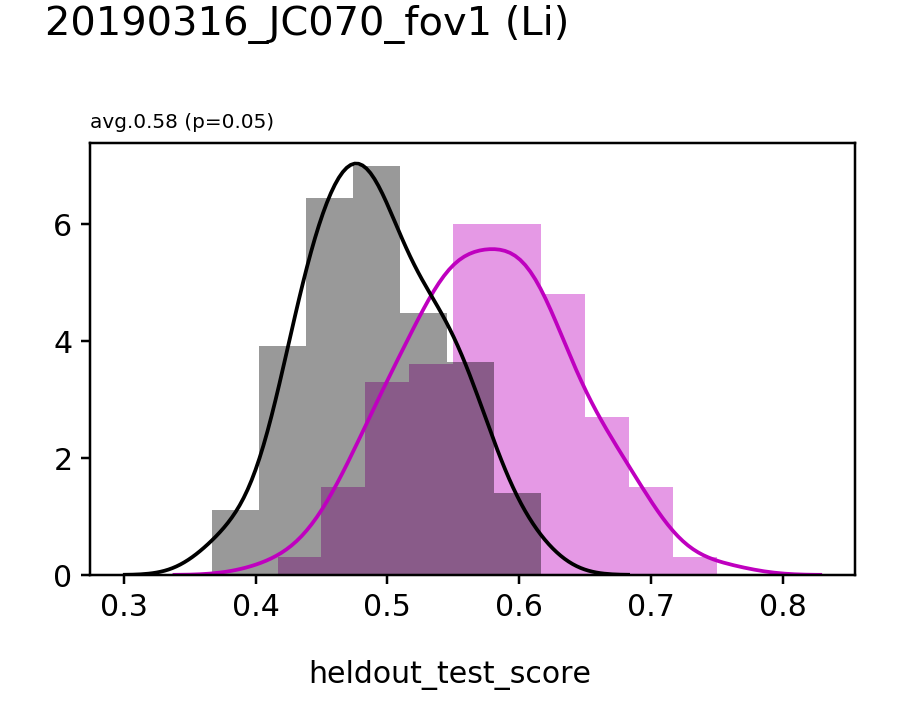

In [50]:
dk = '20190316_JC070_fov1'
va = 'Li'
d_ = traindf[(traindf.visual_area==va) & (traindf.datakey==dk) ].copy()
metric='heldout_test_score'

if 'train_transform' in d_.columns:
    fig, axn = pl.subplots(1, 5, figsize=(10,4), sharex=True, sharey=True)

    for ai, (transf, g) in enumerate(d_.groupby(['train_transform'])):
        ax = axn[ai]
        mean_score = g[g['condition']=='data'][metric].mean()
        percentile = np.mean(mean_score < g[g['condition']=='shuffled'][metric])
        ax.set_title('%s: \navg.%.2f (p=%.2f)' % (str(transf), mean_score, percentile), loc='left', fontsize=8)
        sns.distplot(g[g['condition']=='data'][metric], color='m', ax=ax)
        sns.distplot(g[g['condition']=='shuffled'][metric], color='k', ax=ax)
        ax.set_xlabel('')
    fig.text(0.5, 0.05, metric, ha='center', fontsize=12)
    fig.text(0.05, 0.95, '%s (%s)' % (dk, va), fontsize=16)
else:
    fig, ax = pl.subplots(1, 1, figsize=(5,4), sharex=True, sharey=True)

    mean_score = d_[d_['condition']=='data'][metric].mean()
    percentile = np.mean(mean_score < d_[d_['condition']=='shuffled'][metric])
    ax.set_title('avg.%.2f (p=%.2f)' % ( mean_score, percentile), loc='left', fontsize=8)
    sns.distplot(d_[d_['condition']=='data'][metric], color='m', ax=ax)
    sns.distplot(d_[d_['condition']=='shuffled'][metric], color='k', ax=ax)
    ax.set_xlabel('')
    fig.text(0.5, 0.05, metric, ha='center', fontsize=12)
    fig.text(0.05, 0.95, '%s (%s)' % (dk, va), fontsize=16)


pl.subplots_adjust(bottom=0.2, left=0.1, right=0.95, wspace=0.5, top=0.8)

In [118]:
# d_ = all_df[(all_df.visual_area=='Li') & (all_df.datakey=='20191018_JC113_fov1')].copy()
# mean_score = d_[d_['condition']=='data'][metric].mean()
# percentile = np.mean(mean_score < d_[d_['condition']=='shuffled'][metric])
# print(mean_score, percentile)

# fig, ax = pl.subplots(figsize=(4,3))
# sns.distplot(d_[d_.condition=='data'][metric], color='m', ax=ax)
# sns.distplot(d_[d_.condition=='shuffled'][metric], color='k', ax=ax)
# ax.axvline(x=0.5)

In [57]:
percentiles

C              datakey  heldout_MI  heldout_aMI heldout_log2MI  \
0     0.343  20190314_JC070_fov1   0.0172366    0.0125926      0.0248672   
1   13.6735  20190316_JC070_fov1   0.0208124    0.0178949       0.030026   
2   22.6465  20190319_JC067_fov1  0.00721958  -0.00228272      0.0104156   
3   10.4396  20190320_JC067_fov1   0.0102243   0.00142102      0.0147505   
4   10.4955  20190321_JC070_fov1   0.0107237  0.000227421      0.0154711   
5    0.0316  20190602_JC091_fov1     0.18317     0.254736       0.264258   
6    34.683  20190606_JC091_fov1   0.0263959    0.0267948      0.0380812   
7   1.69156  20190607_JC091_fov1   0.0575733     0.071594      0.0830607   
8   42.2236  20190609_JC099_fov1   0.0635038    0.0802648      0.0916166   
9   10.2527  20190612_JC099_fov1   0.0214344    0.0186862      0.0309233   
10   5.4154  20190614_JC091_fov1   0.0431319    0.0504976      0.0622262   
11  24.1368  20190617_JC099_fov1   0.0535186    0.0583757       0.077211   
12  31.4016  20191018_JC113_fov1   0.0292051    0.0345994       0.042134   
13  53.7625  20191111_JC120_fov1   0.0275265    0.0277137      0.0397124   
14  89.0183  20190306_JC061_fov3   0.0111537   0.00378371      0.0160914   
15  5.55274  20190322_JC073_fov1   0.0310799    0.0328932      0.0448388   
16  21.6636  20190327_JC073_fov1  0.00962418   0.00783386      0.0138848   
17  0.20521  20190430_JC078_fov1   0.0611309    0.0763422      0.0881933   
18  63.6967  20190504_JC078_fov1    0.079114     0.103019       0.114137   
19  0.18073  20190506_JC080_fov1   0.0523211    0.0635057      0.0754833   
20   0.0316  20190508_JC083_fov1    0.176485     0.244963       0.254614   
21  15.8396  20190509_JC078_fov1   0.0140103   0.00779271      0.0202125   
22  0.29494  20190512_JC083_fov1   0.0697414    0.0897469       0.100616   
23  0.11251  20190513_JC078_fov1   0.0860778     0.112835       0.124184   
24  0.25885  20190517_JC083_fov1   0.0583325    0.0702058       0.084156   
25  0.02575  20190525_JC084_fov1    0.128812     0.175663       0.185836   
26  0.06301  20190603_JC080_fov1   0.0184744    0.0144117       0.026653   
27  21.1167  20190618_JC097_fov1   0.0164014    0.0113415      0.0236622   
28  0.84574  20190627_JC091_fov1    0.039306     0.044916      0.0567066   
29   1.5076  20191111_JC120_fov1  0.00676352  -0.00299979      0.0097577   
30  13.1947  20190420_JC076_fov1  0.00869197  0.000154499      0.0125399   
31  3.12364  20190501_JC076_fov1    0.077114      0.10012       0.111252   
32  4.53061  20190504_JC078_fov1   0.0220105    0.0195884      0.0317545   
33    0.046  20190507_JC083_fov1     0.35154     0.501009       0.507165   
34  17.0067  20190508_JC083_fov1   0.0282605    0.0282119      0.0407712   
35  28.5688  20190509_JC078_fov1   0.0579641      0.07214      0.0836245   
36  0.01459  20190510_JC083_fov1    0.317594     0.452422       0.458192   
37  0.01144  20190511_JC083_fov1    0.219318     0.307869       0.316409   
38  31.3178  20190512_JC083_fov1   0.0113007   0.00434958      0.0163035   
39  18.0734  20190517_JC083_fov1   0.0104476 -0.000137716      0.0150727   
40   0.0919  20190522_JC084_fov1    0.179296     0.249405       0.258669   
41   0.0352  20190613_JC097_fov1    0.114172     0.154281       0.164716   
42  0.03871  20190616_JC097_fov1    0.168351      0.23342       0.242879   
43  0.03097  20190622_JC085_fov1   0.0896784     0.118498       0.129379   
44  0.04591  20191006_JC110_fov1   0.0990072     0.133133       0.142837   

   heldout_test_score mean_score n_iterations n_trials percentile session  \
0            0.563833   0.563833          100     1350       0.19     inf   
1            0.576333   0.576333          100     1350       0.05     inf   
2            0.482333   0.482333          100     1350       0.69     inf   
3            0.504667   0.504667          100     1350       0.28     inf   
4               0.472      0.472          100     1125       0.76     inf   
5            0.785172   0.785172          100     1

In [56]:
pass_thr=0.05 
# pass_acc = percentiles[percentiles.percentile < pass_thr].copy()
# print(percentiles.groupby(['visual_area'])['datakey'].count().reset_index())
best_percentile = percentiles.groupby(['visual_area', 'datakey', 'n_trials'])['percentile'].min().reset_index()
passd = best_percentile[best_percentile['percentile']<=pass_thr][['visual_area', 'datakey', 'n_trials']]
pass_shuffle = [(v, d) for (v, d),g in passd.groupby(['visual_area', 'datakey'])]

print("Counts, pre-filter:")
print(traindf[['visual_area', 'datakey']].drop_duplicates()\
      .groupby(['visual_area'])['datakey'].count().reset_index()) ##[['visual_area', 'datakey', 'percentile']])

print("Percentile %.2f of shuffled:" % pass_thr)
print(passd.groupby(['visual_area'])['datakey'].count().reset_index()) ##[['visual_area', 'datakey', 'percentile']])

#### and # of pupil trials missing is below some threshold
min_ntrials=300 #500 #1000
pass_acc = passd[passd.n_trials>=min_ntrials]

#### Only include dsets where overall accuracy > shuffled
# pass_acc = pd.concat([g for (visual_area, datakey), g \
#             in meandf[meandf['arousal']=='all'].groupby(['visual_area', 'datakey']) \
#                       if round(g['fold_over_shuffle'].unique(), 1)>0.])
passdf0 = pd.concat([meandf[(meandf.visual_area==v) & (meandf.datakey==dk)] \
                       for (v, dk), g in pass_acc.groupby(['visual_area', 'datakey'])])

#### and # of pupil trials missing is below some threshold
min_frac = .3
passdf = passdf0[(passdf0['fraction_missing']<min_frac)]

arousaldf = passdf[passdf['arousal'].isin(['high', 'low'])].copy()

print("Missing a min frac %.2f due to pupil:" % pass_thr)
print(passdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

Counts, pre-filter:
  visual_area  datakey
0          Li       15
1          Lm       16
2          V1       15
Percentile 0.05 of shuffled:
  visual_area  datakey
0          Li       10
1          Lm       11
2          V1       11
Missing a min frac 0.05 due to pupil:
             datakey
visual_area         
Li                 7
Lm                10
V1                 8


<IPython.core.display.Javascript object>


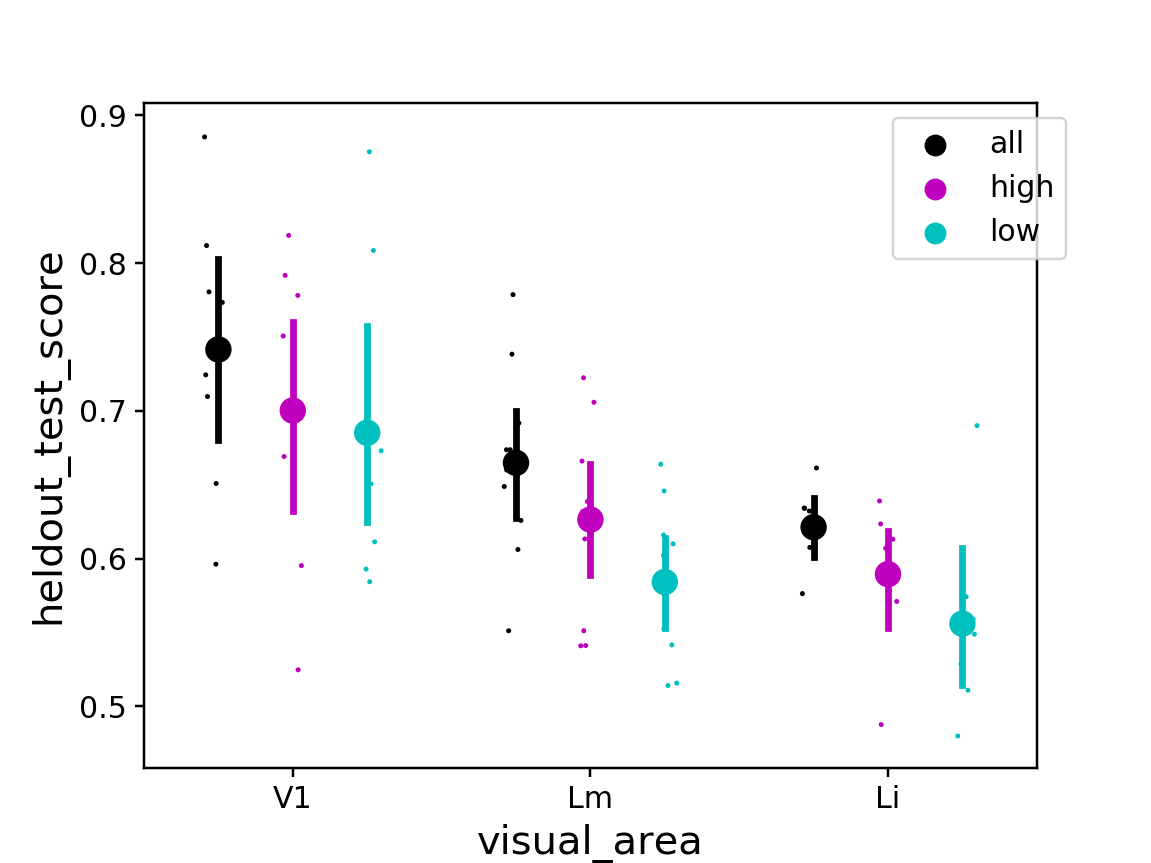

In [57]:
# metric = 'fold_over_shuffle'
metric = 'heldout_test_score'
plotdf = passdf[(passdf.condition=='data') & (passdf.n_cells>=0)].copy()
arousal_colors = {'all': 'k', 'low': 'c', 'high': 'm'}
fig, ax = pl.subplots()
sns.stripplot(x='visual_area', y=metric, data=plotdf, ax=ax,
             hue='arousal', dodge=True, order=visual_areas, palette=arousal_colors, size=2)
sns.pointplot(x='visual_area', y=metric, data=plotdf, ax=ax,
             hue='arousal', dodge=.5, order=visual_areas, palette=arousal_colors, join=False, scale=1.2)
aggr.crop_legend_labels(ax, n_hues=3, bbox_to_anchor=(1,1), loc='upper right')

In [61]:
passdf.head()

visual_area              datakey condition arousal         C  fit_time  \
6           Li  20190316_JC070_fov1      data     all  13.67353  0.012210   
7           Li  20190316_JC070_fov1      data    high   6.51700  0.001520   
8           Li  20190316_JC070_fov1      data     low  13.52836  0.002611   
9           Li  20190316_JC070_fov1  shuffled     all   4.29490  0.003894   
10          Li  20190316_JC070_fov1  shuffled    high  16.04152  0.002747   

    heldout_MI  heldout_aMI  heldout_log2MI  heldout_test_score  \
6     0.020812     0.017895        0.030026            0.576333   
7     0.065544     0.057402        0.094560            0.639000   
8     0.013697    -0.000752        0.019760            0.480000   
9     0.006136    -0.003589        0.008853            0.490667   
10    0.012868    -0.000513        0.018564            0.495000   

            ...           score_time  test_score  train_score  n_cells  \
6           ...             0.000362    0.576875     0.612969      7.0   
7           ...             0.000251    0.616525     0.718805      7.0   
8           ...             0.000253    0.506816     0.577069      7.0   
9           ...             0.000361    0.508083     0.571573      7.0   
10          ...             0.000252    0.541750     0.593229      7.0   

    n_trials  iteration  fraction_missing  n_missing  n_pass  \
6     1350.0       49.5               0.0          0     300   
7      450.0       49.5               0.0          0     300   
8      450.0       49.5               0.0          0     300   
9     1350.0       49.5               0.0          0     300   
10     450.0       49.5               0.0          0     300   

    feature_sample_ratio  
6               0.023333  
7               0.023333  
8               0.023333  
9               0.023333  
10              0.023333  

[5 rows x 21 columns]

# Drop repeats

In [90]:
metric = 'heldout_test_score'

# Drop repeat FOVs
all_curr_dsets = pd.concat([CELLS[(CELLS.visual_area==v) & (CELLS.datakey==dk)] \
           for (v, dk), g in passdf.groupby(['visual_area', 'datakey'])])\
            .groupby(['visual_area', 'datakey']).count().reset_index()
all_curr_dsets = putils.split_datakey(all_curr_dsets)
curr_dsets = aggr.select_best_fovs(all_curr_dsets)

excl_dsets = [] #['20190507_JC083_fov1'] #, '20190501_JC076_fov1'] #, '20190617_JC099_fov1'] #'20191018_JC113_fov1']

passdf_drop = pd.concat([passdf[(passdf.visual_area==v) & (passdf.datakey==dk) & ~(passdf.datakey.isin(excl_dsets))] \
                         for (v, dk), g in curr_dsets.groupby(['visual_area', 'datakey'])])
arousaldf_drop = passdf_drop[passdf_drop.arousal.isin(['high', 'low'])].copy()


print("Drop repeats:")
print(passdf_drop[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())
#print(xdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

[V1] Animalid does not exist: JC078 
Drop repeats:
             datakey
visual_area         
Li                 7
Lm                 6
V1                 6


In [92]:
drop_repeats = False
dset_str = '_aboveshuffle_drop_repeats' if drop_repeats else '_aboveshuffle_alldsets'
xdf = arousaldf_drop.copy() if drop_repeats else arousaldf.copy()
print(xdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

# passdf[['visual_area','datakey', 'n_cells', 'arousal', 'n_trials', 'fraction_missing']].drop_duplicates()

             datakey
visual_area         
Li                 7
Lm                10
V1                 8


<IPython.core.display.Javascript object>


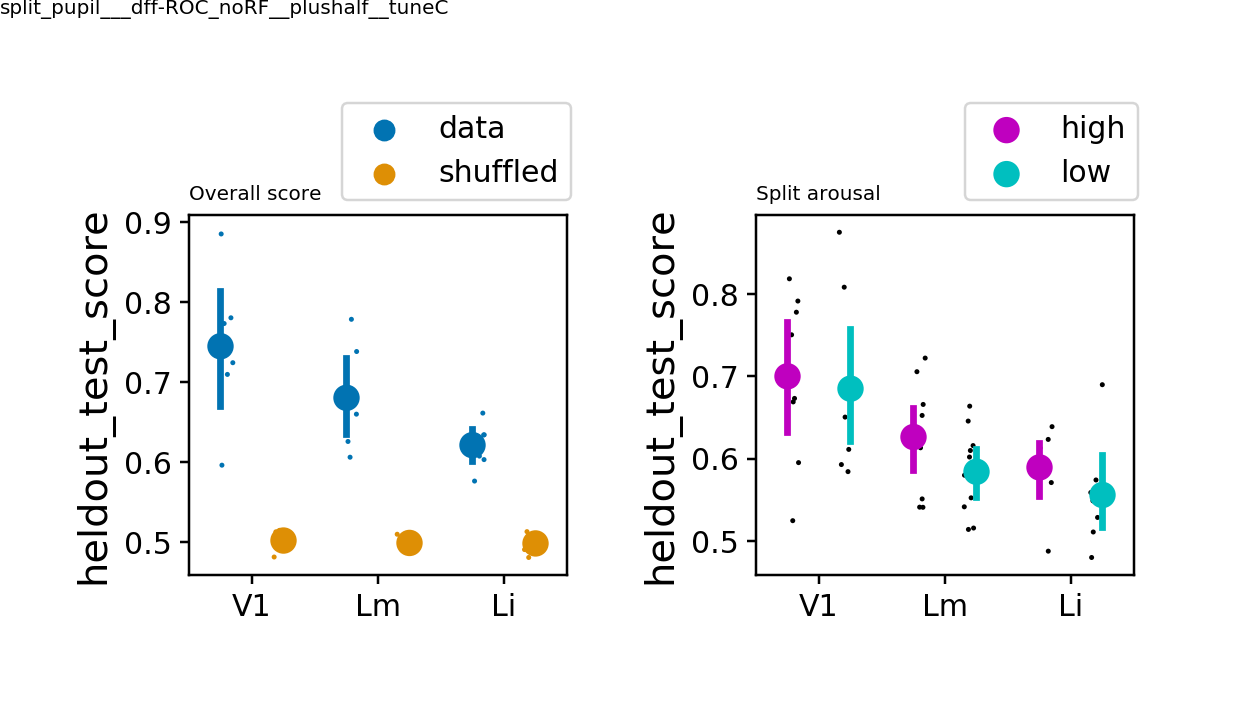

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil/controls', 'compare_shuffle_heldout_test_score___aboveshuffle_alldsets__split_pupil___dff-ROC_noRF__plushalf__tuneC')


In [93]:
metric = 'heldout_test_score' #'fold_over_shuffle'
fig, axn = pl.subplots(1,2, figsize=(7,4), sharey=False, sharex=True)

ax=axn[0]
ax.set_title('Overall score', loc='left', fontsize=8)
sns.stripplot(x='visual_area', y='heldout_test_score', data=passdf_drop[passdf_drop['arousal']=='all'], ax=ax, 
              hue='condition', dodge=True, palette='colorblind', order=visual_areas, size=2)  

sns.pointplot(x='visual_area', y='heldout_test_score', data=passdf_drop[passdf_drop['arousal']=='all'], ax=ax, 
              hue='condition', dodge=0.5, palette='colorblind', join=False, order=visual_areas, scale=1.2)  
aggr.crop_legend_labels(ax, n_hues=2, loc='lower right', bbox_to_anchor=(1,1))
ax.set_xlabel('')

ax=axn[1]
ax.set_title('Split arousal', loc='left', fontsize=8)
sns.pointplot(x='visual_area', y=metric, data=xdf[xdf['condition']=='data'], ax=ax, 
              hue='arousal', dodge=0.5, palette=('m', 'c'), order=visual_areas, join=False, zorder=-1, scale=1.2)
sns.stripplot(x='visual_area', y=metric, data=xdf[xdf['condition']=='data'], ax=ax, 
              hue='arousal', dodge=True, order=visual_areas, palette=('k', 'k'), marker='o', zorder=0, size=2)
aggr.crop_legend_labels(ax, n_hues=2, loc='lower right', bbox_to_anchor=(1,1))
ax.set_xlabel('')

pl.subplots_adjust(bottom=0.2, left=0.15, wspace=0.5, top=0.7)
putils.label_figure(fig, data_id)

figname = 'compare_shuffle_%s__%s__%s' % (metric, dset_str, data_id)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

## Compared paired (high/low)

In [94]:
print(xdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

if test_type is not None:
    bothpass = pd.concat([g for (v, k, t), g in xdf[(xdf.condition=='data') & (xdf.novel)]\
                    .groupby(['visual_area', 'datakey','train_transform']) \
                if (float(g[g.arousal=='high']['fold_over_shuffle'])>0. )
                 & (float(g[g.arousal=='low']['fold_over_shuffle'])>0.)])

    print(bothpass[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

             datakey
visual_area         
Li                 7
Lm                10
V1                 8


<IPython.core.display.Javascript object>


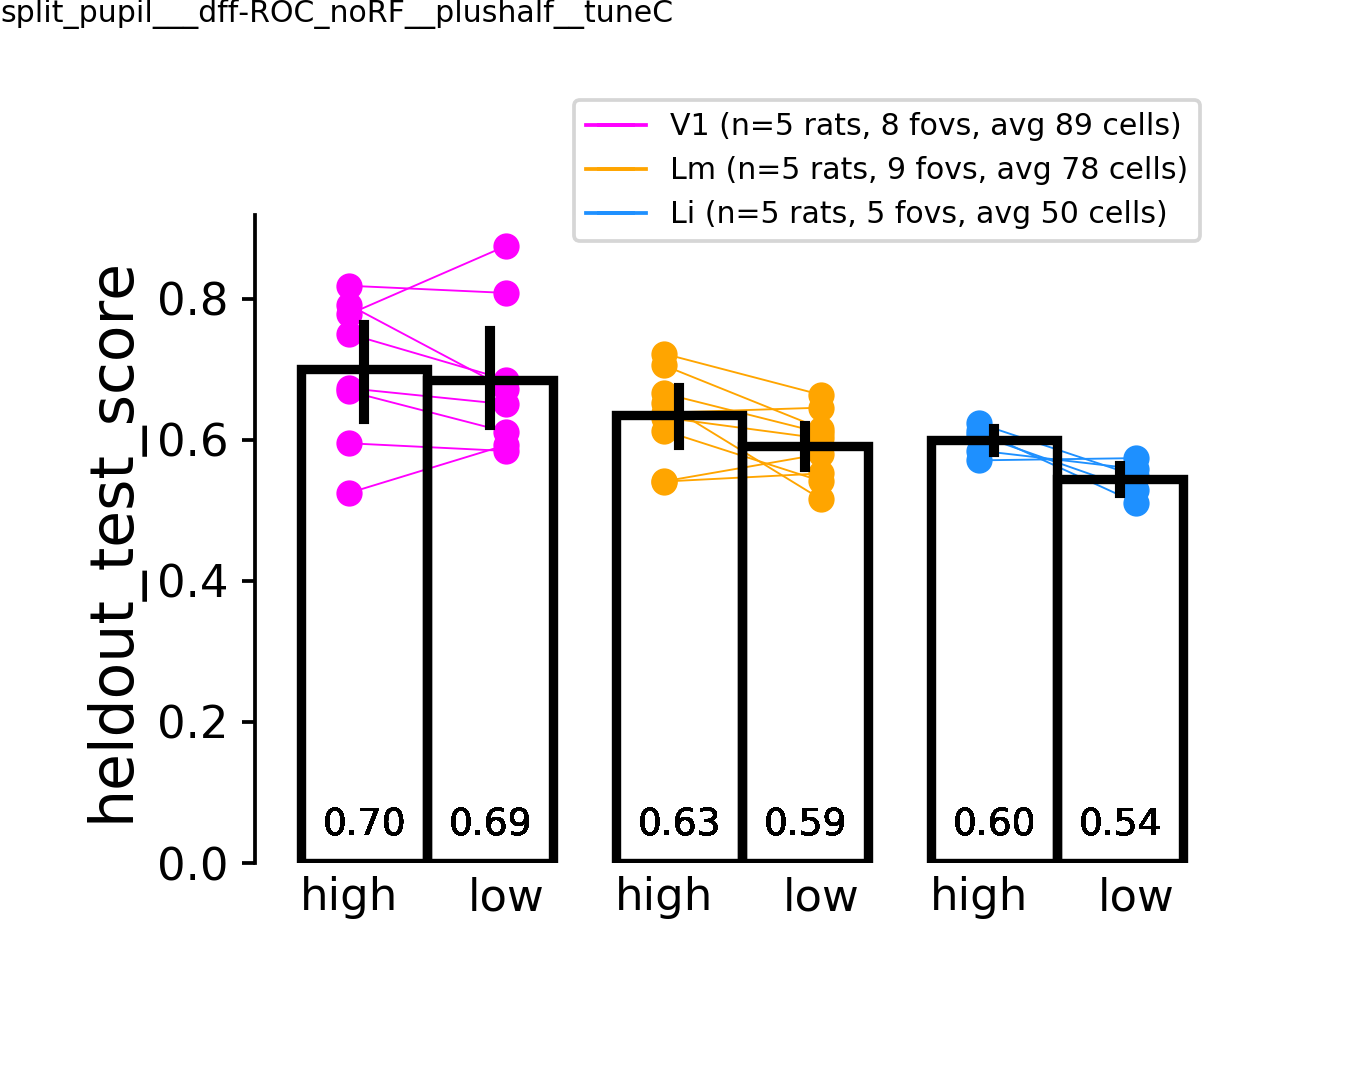

(t-stat:0.60, p=0.57)
(t-stat:2.32, p=0.05)
(t-stat:2.90, p=0.04)
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil/controls', 'paired_hi-lo_heldout_test_score___aboveshuffle_alldsets__split_pupil___dff-ROC_noRF__plushalf__tuneC')


In [96]:
#min_ncells=5
min_ncells=10
min_frac=.5

#xdf = arousaldf_drop.copy() if drop_repeats else arousaldf.copy()

#metric='fold_over_shuffle'
metric='heldout_test_score'
# plotd = bothpass[(bothpass['condition']=='data')
#                  & (bothpass['n_cells']>=min_ncells) & (bothpass['fraction_missing']<=min_frac)]

if test_type is not None:
    novel_by_fov = xdf[xdf.novel].groupby(['visual_area', 'datakey', 'arousal', 'condition']).mean().reset_index()
    plotd = novel_by_fov[(novel_by_fov['condition']=='data')
                     & (novel_by_fov['n_cells']>=min_ncells) ] #& (xdf['fraction_missing']<=min_frac)]
else:
    plotd = xdf[(xdf['condition']=='data')
                     & (xdf['n_cells']>=min_ncells) ] #& (xdf['fraction_missing']<=min_frac)]

c1='high'
c2='low'
compare_var='arousal'

fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
ax = aggr.plot_pairwise_by_axis(plotd, curr_metric=metric, c1=c1, c2=c2, compare_var=compare_var,
                                ax=ax, area_colors=area_colors, legend=True, bbox_to_anchor=(1., 1.2))
ax.set_xlabel('')

pl.subplots_adjust(bottom=0.2, left=0.2, wspace=0.5, top=0.8)
putils.label_figure(fig, data_id)

figname = 'paired_hi-lo_%s__%s__%s' % (metric, dset_str, data_id)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [97]:
plotd[plotd.visual_area=='V1'][['datakey', 'arousal', metric, 'n_cells', 'n_trials']]

datakey arousal  heldout_test_score  n_cells  n_trials
205  20190507_JC083_fov1    high            0.778095     97.0     495.0
206  20190507_JC083_fov1     low            0.875263     97.0     495.0
211  20190508_JC083_fov1    high            0.595294     18.0     468.0
212  20190508_JC083_fov1     low            0.584348     18.0     468.0
217  20190509_JC078_fov1    high            0.524737     12.0     500.0
218  20190509_JC078_fov1     low            0.592941     12.0     500.0
229  20190511_JC083_fov1    high            0.818696     88.0     498.0
230  20190511_JC083_fov1     low            0.808500     88.0     498.0
247  20190522_JC084_fov1    high            0.791667    107.0     489.0
248  20190522_JC084_fov1     low            0.672941    107.0     489.0
253  20190613_JC097_fov1    high            0.673333    120.0     458.0
254  20190613_JC097_fov1     low            0.650625    120.0     458.0
259  20190616_JC097_fov1    high            0.750625    184.0     499.0
260  20190616_JC097_fov1     low            0.685385    184.0     499.0
271  20191006_JC110_fov1    high            0.669091     86.0     550.0
272  20191006_JC110_fov1     low            0.611364     86.0     550.0

In [ ]:
fig, axn = pl.subplots(1,3)
for visual_area, g in plotd.groupby(['visual_area']):
    sns.pointplot(x=)

In [87]:
# plotd['relative_fold'] = 0
# for (v, d), g in plotd.groupby(['visual_area', 'datakey']):
#     hi = float(g[g.arousal=='high']['fold_over_shuffle'])
#     lo = float(g[g.arousal=='low']['fold_over_shuffle'])
#     plotd['relative_fold'][g.index] = (hi-lo)/lo

In [88]:
# multi_comp_test='fdr_bh'
# fig, ax = pl.subplots()
# sns.stripplot(x='visual_area', y='relative_fold', data=plotd[plotd.arousal=='high'], ax=ax,
#             hue='visual_area', palette=area_colors, hue_order=visual_areas)

# statresults, ax = aggr.plot_mannwhitney(plotd[plotd.arousal=='high'], metric='relative_fold', 
#                                         multi_comp_test=multi_comp_test, ax=ax)


In [89]:
# plotd[plotd.arousal=='high'][['visual_area', 'datakey', 'relative_fold']]

# Quality control checks

<IPython.core.display.Javascript object>


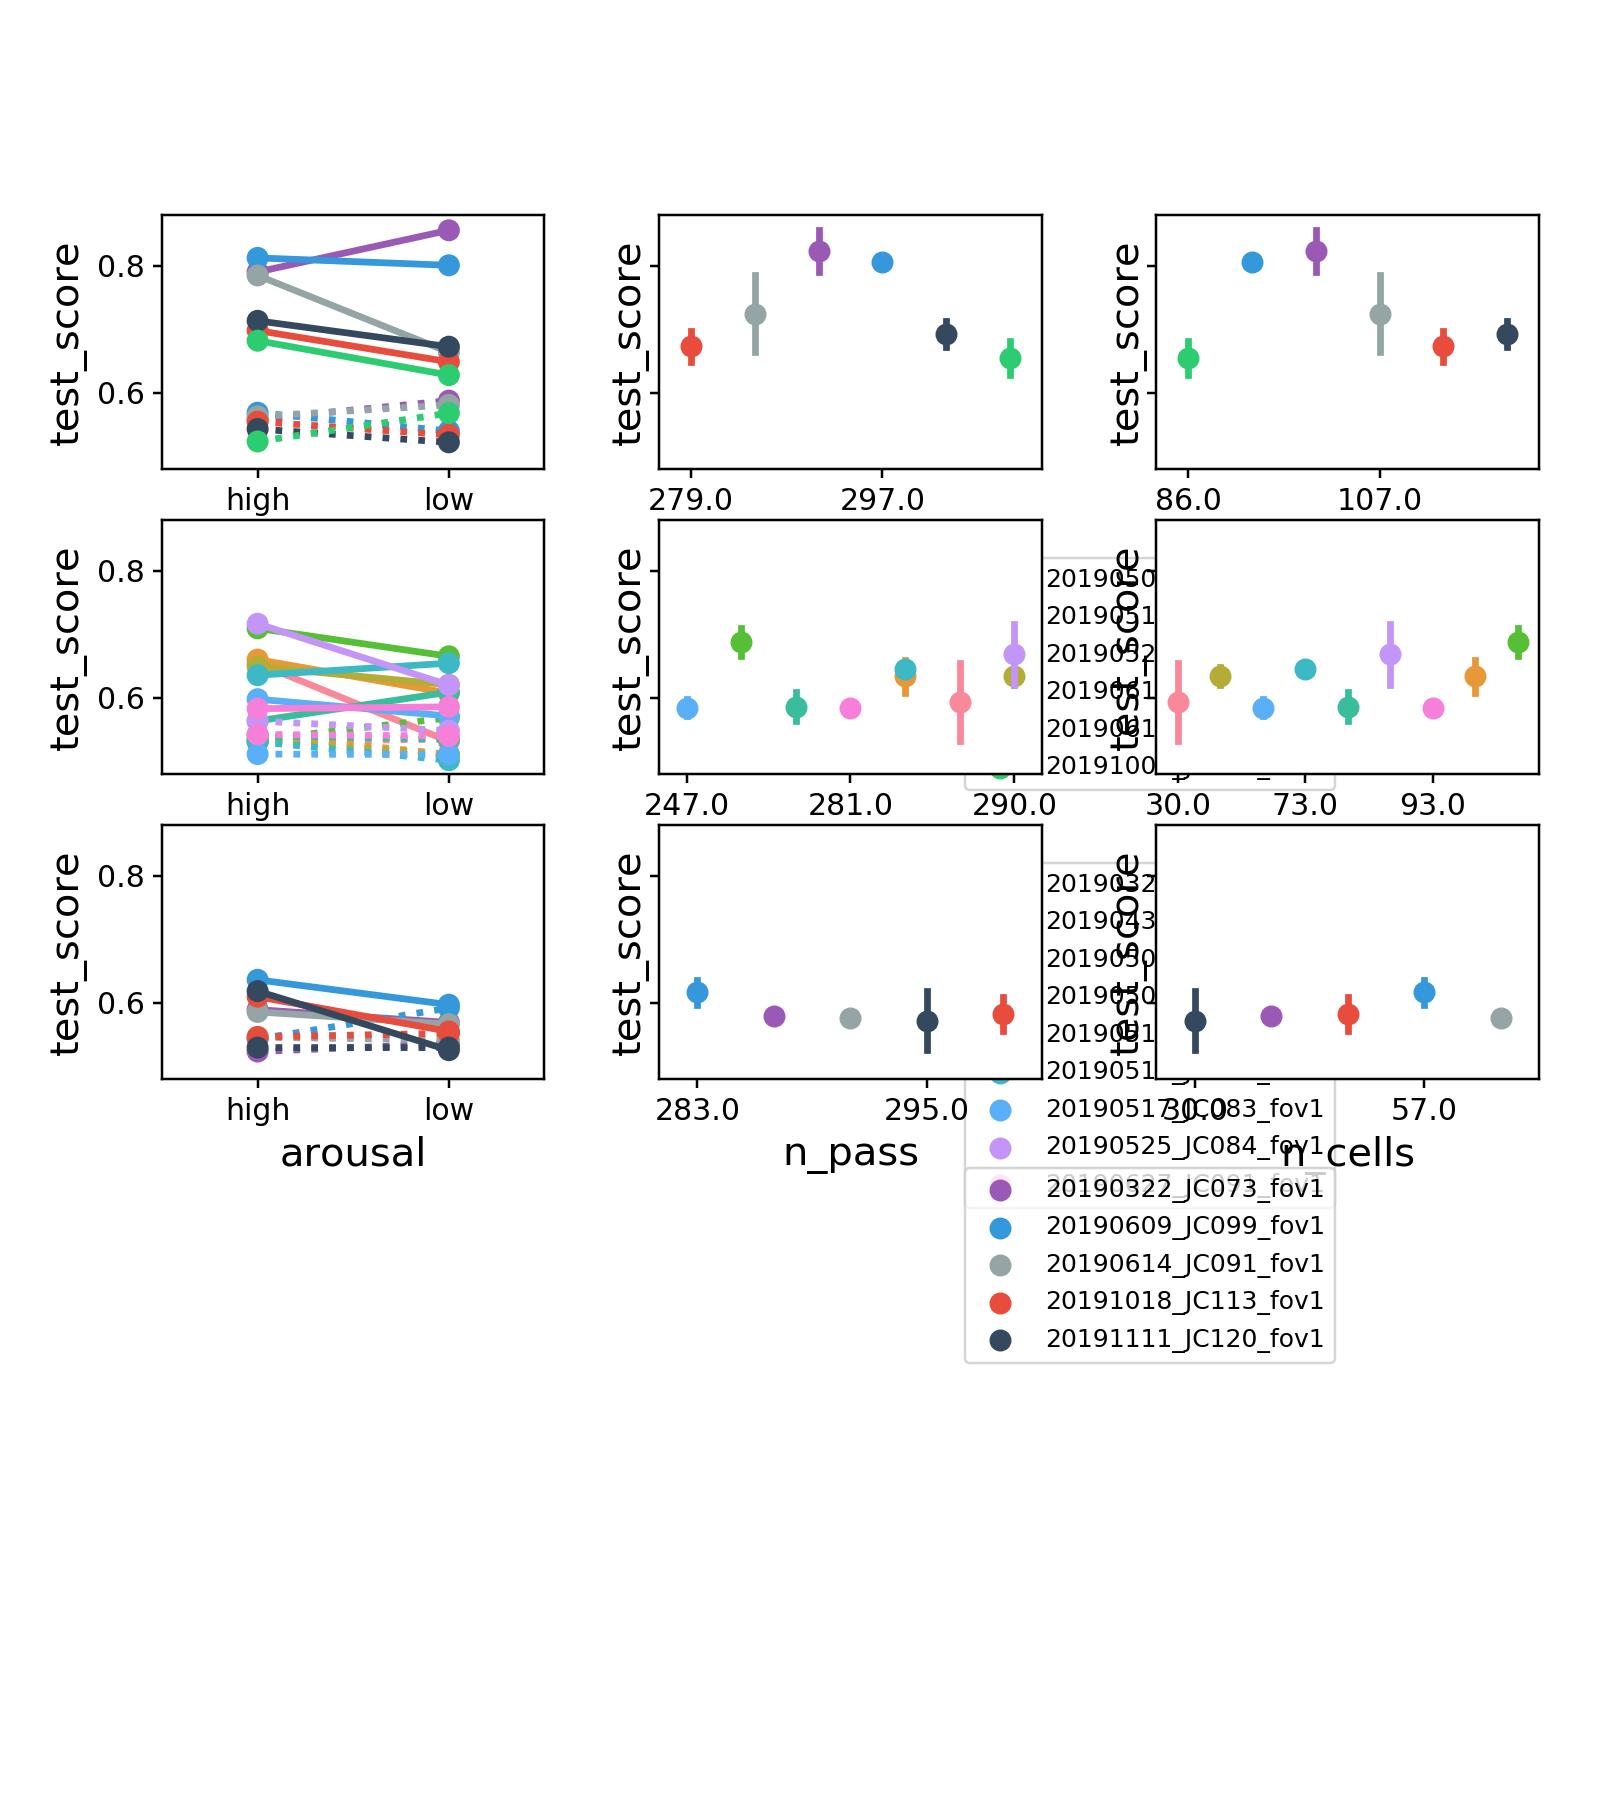

In [105]:
metric='test_score'
min_ncells=20
min_frac=0.3
#visual_area='Li'
plotd0 = xdf[(xdf['n_cells']>=min_ncells) & (xdf['fraction_missing']<=min_frac)]

#p_ = plotd[(plotd['fraction_missing']<0.4) & (plotd['n_cells']>40)]

fig, axn = pl.subplots(3, 3, figsize=(9,10), sharey=True)

for visual_area, plotd in plotd0.groupby(['visual_area']):
    ai = visual_areas.index(visual_area)
    ax=axn[ai, 0]
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=plotd[plotd.condition=='data'], ax=ax)
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=plotd[plotd.condition=='shuffled'], ax=ax, 
                linestyles=':')
    ax.legend_.remove()


    ax=axn[ai, 1]
    sns.pointplot(x='n_pass', y=metric, hue='datakey', data=plotd[plotd.condition=='data'], ax=ax)
    ax.legend_.remove()

    xticks = ax.get_xticks()
    xtick_labels = ax.get_xticklabels()
    ax.set_xticks(xticks[0::3])
    ax.set_xticklabels([round(float(i.get_text()), 1) for i in xtick_labels[0::2]])

    ax=axn[ai, 2]
    sns.pointplot(x='n_cells', y=metric, hue='datakey', data=plotd[plotd.condition=='data'], ax=ax)

    xticks = ax.get_xticks()
    xtick_labels = ax.get_xticklabels()
    ax.set_xticks(xticks[0::3])
    ax.set_xticklabels(xtick_labels[0::3])

    ax.legend(bbox_to_anchor=(0.5, -0.3), ncol=1)

pl.subplots_adjust(left=0.1, right=0.95, wspace=0.3, bottom=0.4)

## Compare input data

In [68]:
print(response_type, responsive_test, responsive_thr)

('dff', 'ROC', 0.05)


In [69]:
#bothpass = putils.split_datakey(bothpass)
xdf = putils.split_datakey(xdf)
# meandf = putils.split_datakey(meandf)

visual_areas=['V1', 'Lm', 'Li']
d_=[]
for (visual_area, animalid, session, fov, datakey), g  \
        in xdf.groupby(['visual_area', 'animalid', 'session', 'fov', 'datakey']):
        
    curr_id = dc.create_results_id(prefix=analysis_type, C_value=C_value, 
                        visual_area=visual_area,
                        response_type=response_type, responsive_test=responsive_test, 
                        overlap_thr=overlap_thr, trial_epoch=trial_epoch)
    
    curr_inputfiles = glob.glob(os.path.join(rootdir, animalid, session, fov,
                        'combined_blobs_static', 'traces',
                       '%s*' % traceid, 'decoding', 'inputdata_%s*.pkl' % curr_id))
    # print("%s: %i files" % (visual_area, len(curr_inputfiles)))
    for cf in curr_inputfiles:
        with open(cf, 'rb') as f:
            res = pkl.load(f)
            
        #res['neuraldf']['arousal']['high_ixs']
        xd = res['neuraldf'].copy()
        xd['arousal'] = 'all'
        xd['arousal'][res['high_ixs']] = 'high'
        xd['arousal'][res['low_ixs']] = 'low'

        tmpdf = pd.melt(xd, id_vars=['config', 'arousal'], 
                          var_name='cell',value_name='response')
        tmpdf['visual_area'] = visual_area
        tmpdf['datakey'] = datakey
        tmpdf['trial'] = tmpdf.index.tolist()
        d_.append(tmpdf)
        
neurald = pd.concat(d_,axis=0)


In [70]:
meandf = putils.split_datakey(meandf)

no_inputfile=[]
pdata_c['arousal'] = 'all'

for (visual_area, animalid, session, fov, datakey), g  \
        in meandf.groupby(['visual_area', 'animalid', 'session', 'fov', 'datakey']):
    
    pdf = pdata_c[(pdata_c.datakey==datakey)].copy()
    #if len(pdf['arousal'].unique()>1):
    #    continue
    curr_id = dc.create_results_id(prefix=analysis_type, C_value=C_value, 
                        visual_area=visual_area,
                        response_type=response_type, responsive_test=responsive_test, 
                        overlap_thr=overlap_thr, trial_epoch=trial_epoch)
    
    curr_inputfiles = glob.glob(os.path.join(rootdir, animalid, session, 'FOV%i_zoom2p0x' % fovnum,
                        'combined_blobs_static', 'traces',
                       '%s*' % traceid, 'decoding', 'inputdata_%s.pkl' % curr_id))
    if len(curr_inputfiles)==0:
        print((visual_area, datakey))
        no_inputfile.append((visual_area, datakey, curr_id))
        continue
        
    assert len(curr_inputfiles)==1, "More than 1 input file: %s" % str(curr_inputfiles)

    with open(curr_inputfiles[0], 'rb') as f:
        res = pkl.load(f)  
    
    for a_type in ['high', 'low']:
        curr_trials = res['%s_ixs' % a_type].astype(int)
        pdata_c['arousal'].loc[pdf[pdf['trial'].isin(curr_trials)].index] = a_type
        
no_inputfile   

('Lm', '20190306_JC061_fov3')


[('Lm',
  '20190306_JC061_fov3',
  'split_pupil_Lm__dff-ROC_noRF__plushalf__tuneC')]

In [71]:
for dk, g in pdata_c.groupby(['datakey']):
    if len(g['arousal'].unique())!=3:
        print(dk, g['arousal'].unique())

('20190306_JC061_fov3', array(['all'], dtype=object))
('20190422_JC076_fov1', array(['all'], dtype=object))
('20190617_JC097_fov1', array(['all'], dtype=object))


In [35]:
pdata_c.head()

trial  frame  pupil_area  frame_int  frame_ix  pupil_fraction     config  \
0    1.0    9.5  593.718311        9.5       9.5        0.582607  config019   
1    2.0    9.5  412.658117        9.5       9.5        0.404935  config002   
2    3.0    9.5  409.877847        9.5       9.5        0.402207  config011   
3    4.0    9.5  451.443446        9.5       9.5        0.442995  config020   
4    5.0    9.5  348.668212        9.5       9.5        0.342143  config001   

               datakey  size  morphlevel  
0  20190512_JC083_fov1  40.0          27  
1  20190512_JC083_fov1  20.0          -1  
2  20190512_JC083_fov1  10.0          14  
3  20190512_JC083_fov1  50.0          27  
4  20190512_JC083_fov1  10.0          -1

In [313]:
# visual_area = 'V1'
# datakey = '20190510_JC083_fov1'
# session, animalid, fovn = putils.split_datakey_str(datakey)

# pdf = pdata_c[(pdata_c.datakey==datakey)].copy()

# curr_id = dc.create_results_id(prefix=analysis_type, C_value=C_value, 
#                     visual_area=visual_area,
#                     response_type=response_type, responsive_test=responsive_test, 
#                     overlap_thr=overlap_thr, trial_epoch=trial_epoch)
# print(curr_id)
# curr_inputfiles = glob.glob(os.path.join(rootdir, animalid, session, 'FOV%i_zoom2p0x' % fovnum,
#                         'combined_blobs_static', 'traces',
#                        '%s*' % traceid, 'decoding', 'inputdata_%s.pkl' % curr_id))#%s' % curr_id)) 



# assert len(curr_inputfiles)==1, "More than 1 input file: %s" % str(curr_inputfiles)

# with open(curr_inputfiles[0], 'rb') as f:
#     res = pkl.load(f)  

# for a_type in ['high', 'low']:
#     curr_trials = res['%s_ixs' % a_type].astype(int)
#     print(len(curr_trials))
#     pdata_c['arousal'].loc[pdf[pdf['trial'].isin(curr_trials)].index] = a_type


### input data:  check distn of stimulus type/size

In [72]:
split = pdata_c[pdata_c['arousal'].isin(['all', 'high', 'low'])].copy()

p_list=[]
for (visual_area, datakey), g in meandf.groupby(['visual_area', 'datakey']):
    pdf = split[(split.datakey==datakey)].copy()
    tmp0 = pdf[['datakey', 'arousal', 'size', 'morphlevel', 'trial' ]]
    tmp0['visual_area'] = visual_area
    p_list.append(tmp0)
splitdf = pd.concat(p_list, axis=0).reset_index(drop=True)
splitdf.head()

split_counts = splitdf.groupby(['visual_area', 'datakey', 'arousal', 'size', 'morphlevel']).count().reset_index()

In [73]:
# mean_for_size = split_counts[split_counts.arousal.isin(['low', 'high'])]\
#                     .groupby(['visual_area', 'datakey', 'arousal', 'size']).sum().reset_index()

# fig, axn = pl.subplots(1,5, figsize=(8,4), sharex=True, sharey=True)

# for ai, (sz, d_) in enumerate(mean_for_size[mean_for_size['arousal'].isin(['high', 'low'])].groupby(['size'])):
    
#     ax = axn[ai]
#     sns.pointplot(x='visual_area', y='trial', hue='arousal', data=d_, ax=ax, dodge=0.5, join=False,
#                  order=visual_areas, palette='colorblind')
#     ax.set_title(sz)
#     if ai<4:
#         ax.legend_.remove()

In [74]:
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil


In [75]:
curr_dst_dir = os.path.join(dst_dir, 'controls')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil/controls


<IPython.core.display.Javascript object>


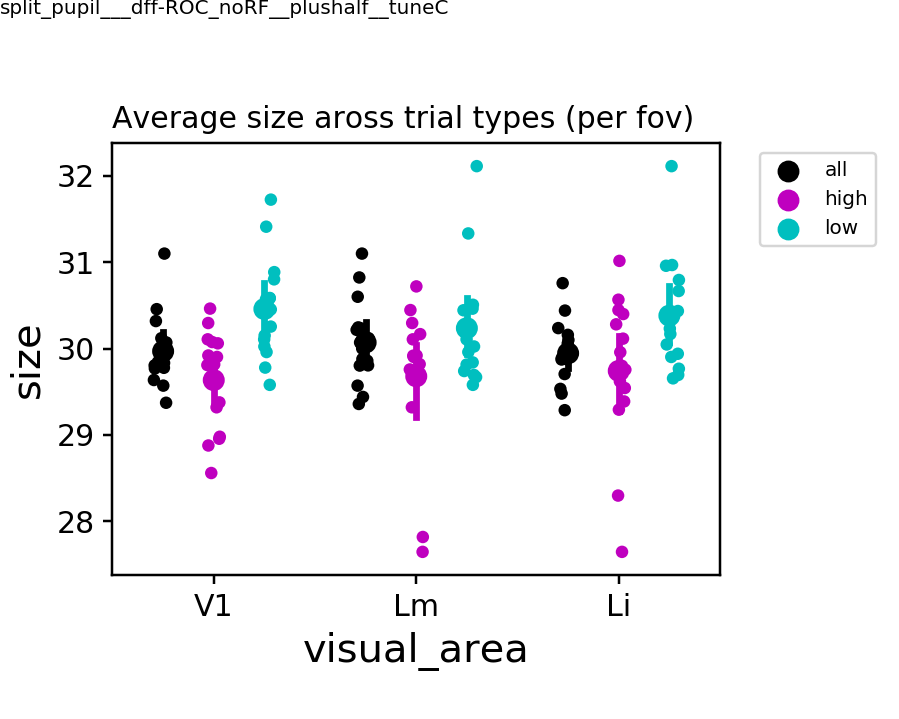

In [76]:
#### Get average size of stimulus across trials in each condition type
mean_size = splitdf.groupby(['visual_area', 'datakey', 'arousal']).mean().reset_index()

fig, ax = pl.subplots(figsize=(5,4))
sns.stripplot(x='visual_area', y='size', hue='arousal', data=mean_size, ax=ax,
             dodge=0.5, palette=arousal_colors, order=visual_areas)
sns.pointplot(x='visual_area', y='size', hue='arousal', data=mean_size, ax=ax,
             dodge=0.5, palette=arousal_colors, order=visual_areas, join=False)
ax.set_title("Average size aross trial types (per fov)", loc='left', fontsize=12)
aggr.crop_legend_labels(ax, n_hues=3, bbox_to_anchor=(0.7, 1), loc='upper left', fontsize=8)
pl.subplots_adjust(right=0.8, bottom=0.2, top=0.8)
putils.label_figure(fig, data_id)

figname = 'avg_sizes_by_fov__%s' % data_id
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

## stimulus size x "arousal" (paired)

<IPython.core.display.Javascript object>


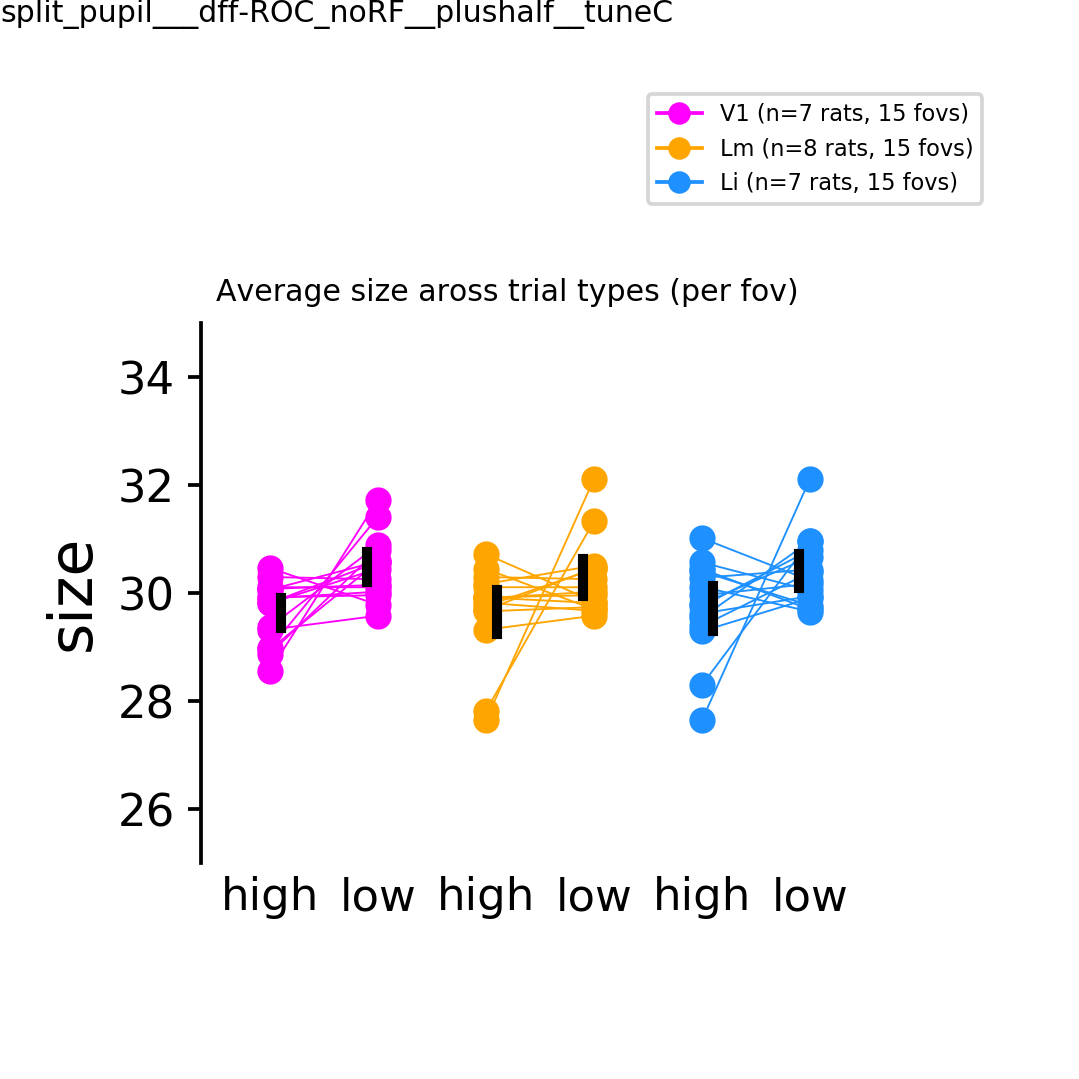

(t-stat:-2.97, p=0.01)
(t-stat:-1.47, p=0.16)
(t-stat:-1.74, p=0.10)


In [107]:
c1='high'
c2='low'
compare_var='arousal'

df_ = mean_size[mean_size['arousal'].isin(['low', 'high'])].copy()

fig, ax = pl.subplots(figsize=(4,4), dpi=dpi)
for aix, visual_area in enumerate(visual_areas):
    plotd = df_[df_['visual_area']==visual_area]
    ax = aggr.plot_paired(plotd, aix=aix, curr_metric='size', c1=c1, c2=c2, compare_var=compare_var,
                                ax=ax, color=area_colors[visual_area])
sns.barplot("visual_area", 'size', data=df_, hue=compare_var, hue_order=[c1, c2], #zorder=0,
                ax=ax, order=visual_areas, errcolor='k', edgecolor='none', facecolor='none')
ax.set_xlabel('')

# Get counts of samples for legend
legend_elements = aggr.get_counts_for_legend(df_, area_colors=area_colors,markersize=5, marker='o')
ax.legend(handles=legend_elements, bbox_to_anchor=(1.2,1.2), loc='lower right', fontsize=6)
        
aggr.set_split_xlabels(ax, a_label=c1, b_label=c2)
df_.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=10, fontcolor='k', xytext=(0,125))
ax.set_ylim([25, 35])
ax.set_title("Average size aross trial types (per fov)", loc='left', fontsize=8)

pl.subplots_adjust(bottom=0.2, left=0.2, wspace=0.5, top=0.7, right=0.8)
putils.label_figure(fig, data_id)



figname = 'avg_sizes_paired_by_fov__%s' % data_id
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

<IPython.core.display.Javascript object>


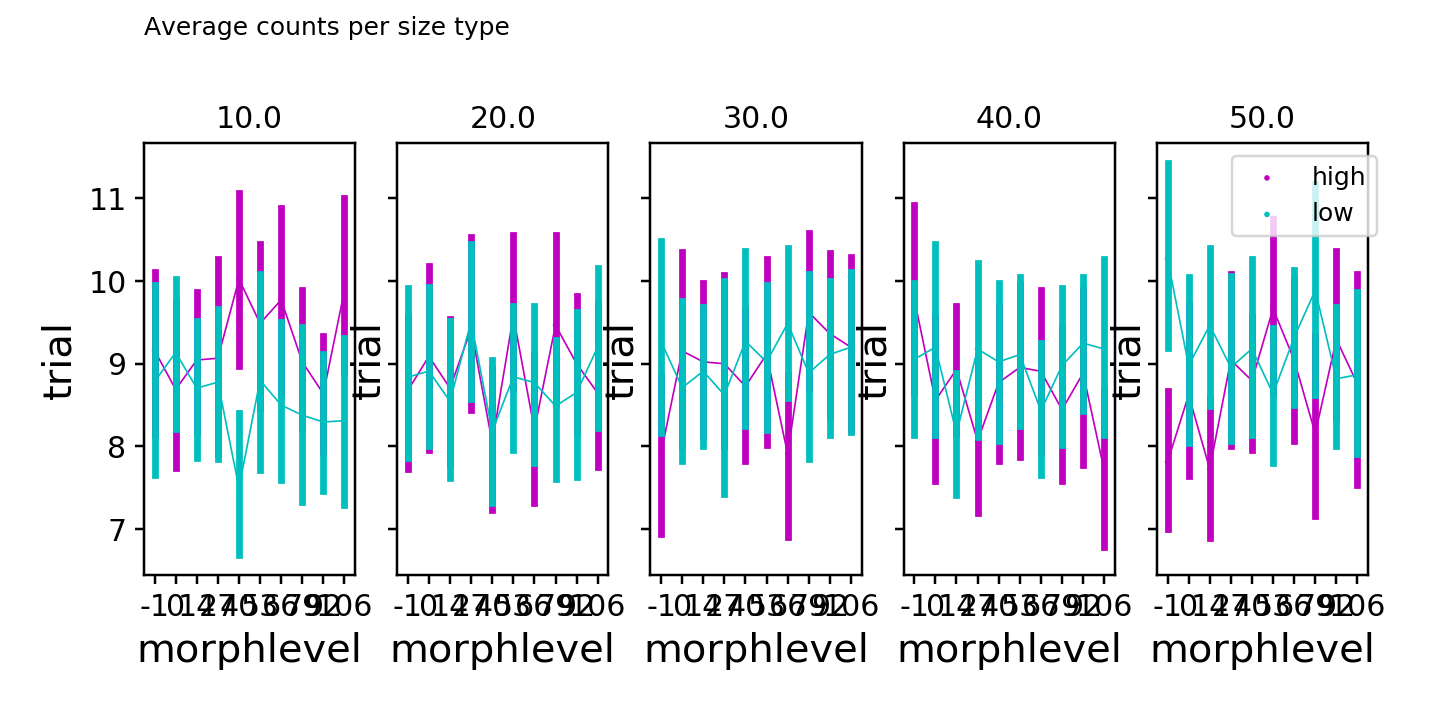

In [78]:
fig, axn = pl.subplots(1,5, figsize=(8,4), sharex=True, sharey=True)
arousal_colors={'all': 'k', 'high': 'm', 'low': 'c'}

for ai, (sz, d_) in enumerate(split_counts[split_counts['arousal'].isin(['high', 'low'])].groupby(['size'])):
    
    ax = axn[ai]
    sns.pointplot(x='morphlevel', y='trial', hue='arousal', data=d_, ax=ax, 
                  dodge=False, join=True, lw=0.5, scale=0.25, palette=arousal_colors)
    ax.legend_.remove()
    ax.set_title(sz)
axn[-1].legend(bbox_to_anchor=(1.1, 1), loc='upper right')
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8)

fig.text(0.1, 0.95, "Average counts per size type")


figname = 'counts_by_stim_size__%s' % data_id
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

<IPython.core.display.Javascript object>


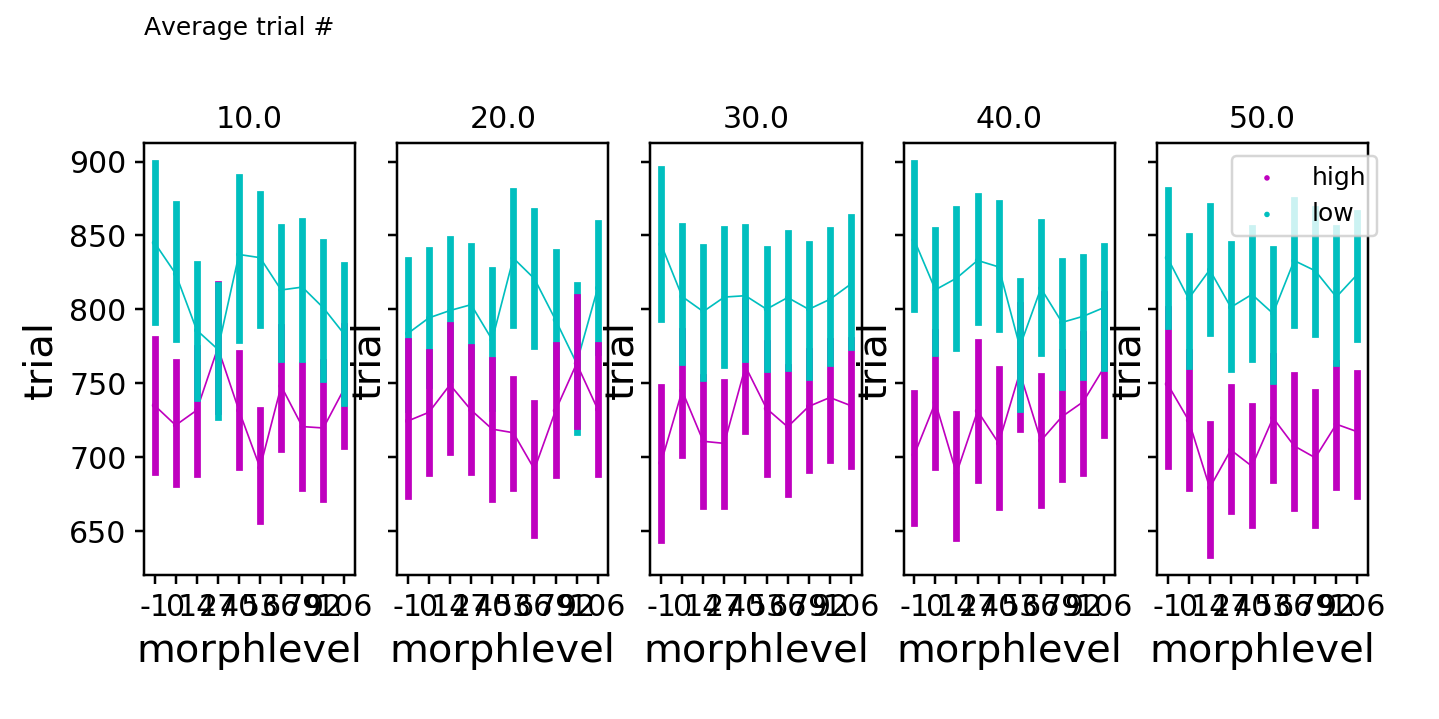

In [79]:
fig, axn = pl.subplots(1,5, figsize=(8,4), sharex=True, sharey=True)
arousal_colors={'all': 'k', 'high': 'm', 'low': 'c'}

for ai, (sz, d_) in enumerate(splitdf[splitdf['arousal'].isin(['high', 'low'])].groupby(['size'])):
    
    ax = axn[ai]
    sns.pointplot(x='morphlevel', y='trial', hue='arousal', data=d_, ax=ax, 
                  dodge=False, join=True, lw=0.5, scale=0.25, palette=arousal_colors)
    ax.legend_.remove()
    ax.set_title(sz)
axn[-1].legend(bbox_to_anchor=(1.1, 1), loc='upper right')
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8)

fig.text(0.1, 0.95, "Average trial #")


figname = 'trialnum_by_stim_size__%s' % data_id
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

# Response magnitudes

In [80]:
means_by_cell = neurald.groupby(['visual_area', 'datakey', 'cell', 'arousal' ]).mean().reset_index()
means_by_cell.head()

means_by_fov = means_by_cell.groupby(['visual_area', 'datakey', 'arousal' ]).mean().reset_index()
means_by_fov.head()

visual_area              datakey arousal        cell  response         trial
0          Li  20190316_JC070_fov1     all  125.714286 -0.025295   4654.713333
1          Li  20190316_JC070_fov1    high  125.714286  0.061682   4635.924444
2          Li  20190316_JC070_fov1     low  125.714286 -0.036387   4882.862222
3          Li  20190322_JC073_fov1     all  219.473684  0.028542  25648.335341
4          Li  20190322_JC073_fov1    high  219.473684  0.178846  25731.117371

<IPython.core.display.Javascript object>


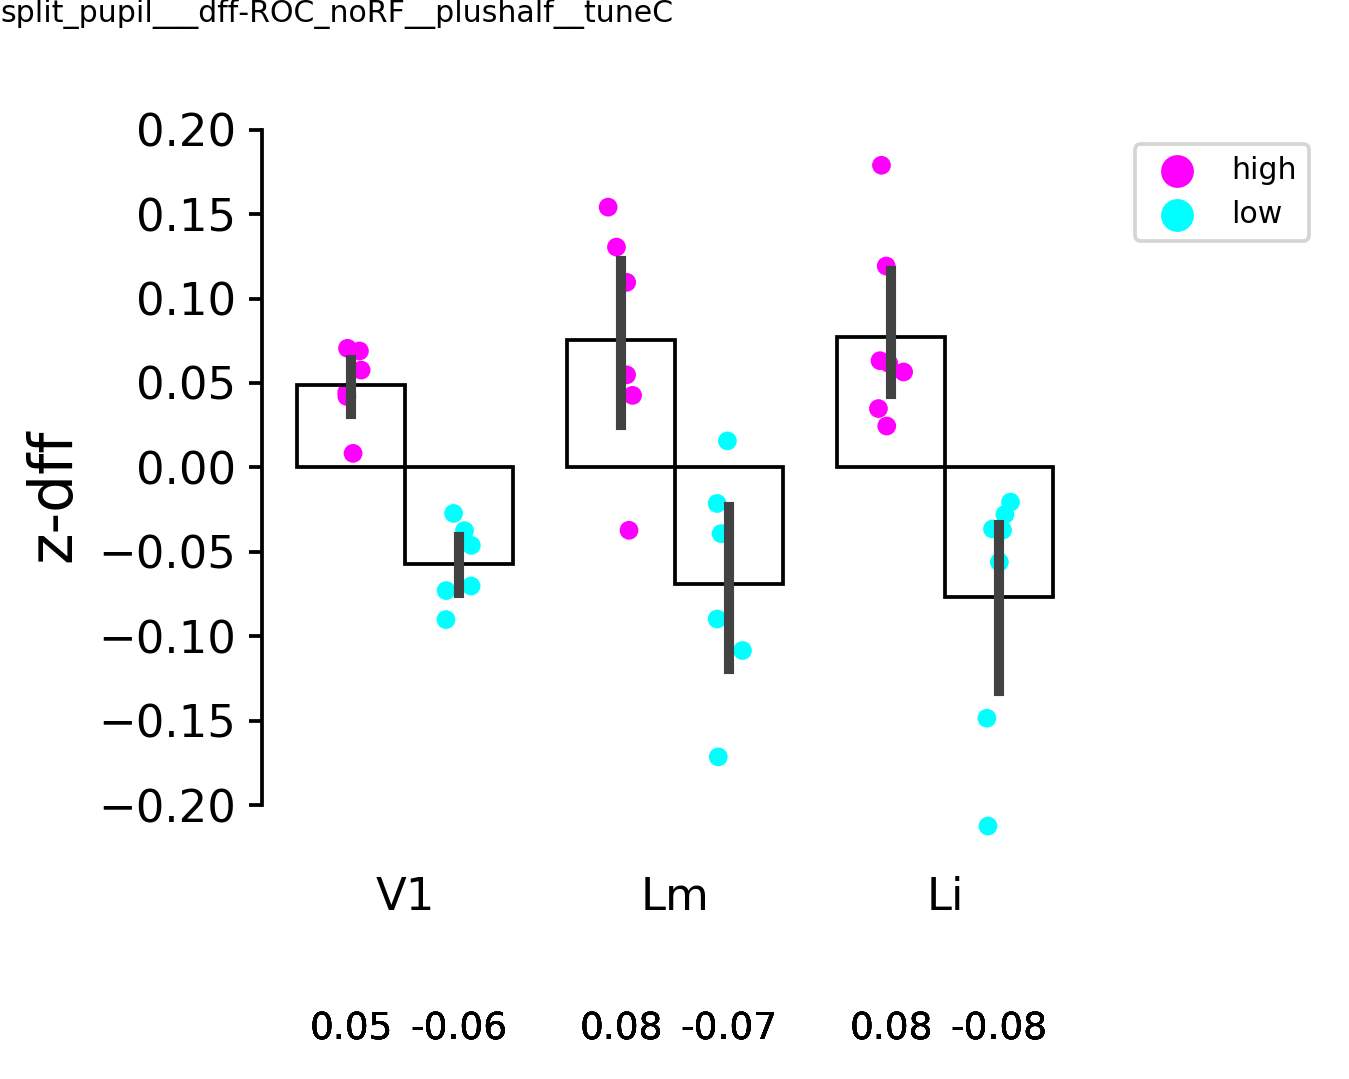

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil/controls', 'mean_dff_by_fov__filtered__split_pupil___dff-ROC_noRF__plushalf__tuneC')


In [81]:
palette=['magenta', 'cyan']
plot_cells=False

if plot_cells:
    plotdf = means_by_cell[means_by_cell['arousal'].isin(['high', 'low'])].copy()
else:
    plotdf = means_by_fov[means_by_fov['arousal'].isin(['high', 'low'])].copy()

markersize=2 if plot_cells else 5
plot_str='all_cells' if plot_cells else 'by_fov'

fig, ax = pl.subplots(dpi=dpi, figsize=(5,4))

sns.stripplot(x='visual_area', y='response', hue='arousal', data=plotdf, ax=ax, 
              palette=palette, dodge=True, zorder=-1, order=visual_areas, size=markersize)
sns.barplot(x='visual_area', y='response', hue='arousal', data=plotdf, ax=ax, zorder=-1, 
            edgecolor=('k', 'k', 'k'), facecolor='none', order=visual_areas)
plotdf.apply(aggr.annotateBars, ax=ax,fontsize=10, fontcolor='k', xytext=(0, -150))

#ax.set_ylim([-1, 2])
sns.despine(trim=True, offset=2, bottom=True)
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
ax.set_ylabel('z-dff')

pl.subplots_adjust(left=0.2, bottom=0.2, right=0.8)
aggr.crop_legend_labels(ax, n_hues=2, bbox_to_anchor=(1., 1), fontsize=8)

putils.label_figure(fig, data_id)
#ax.set_ylim([-1, 2])
figname = 'mean_dff_%s__filtered__%s' % (plot_str, data_id)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>


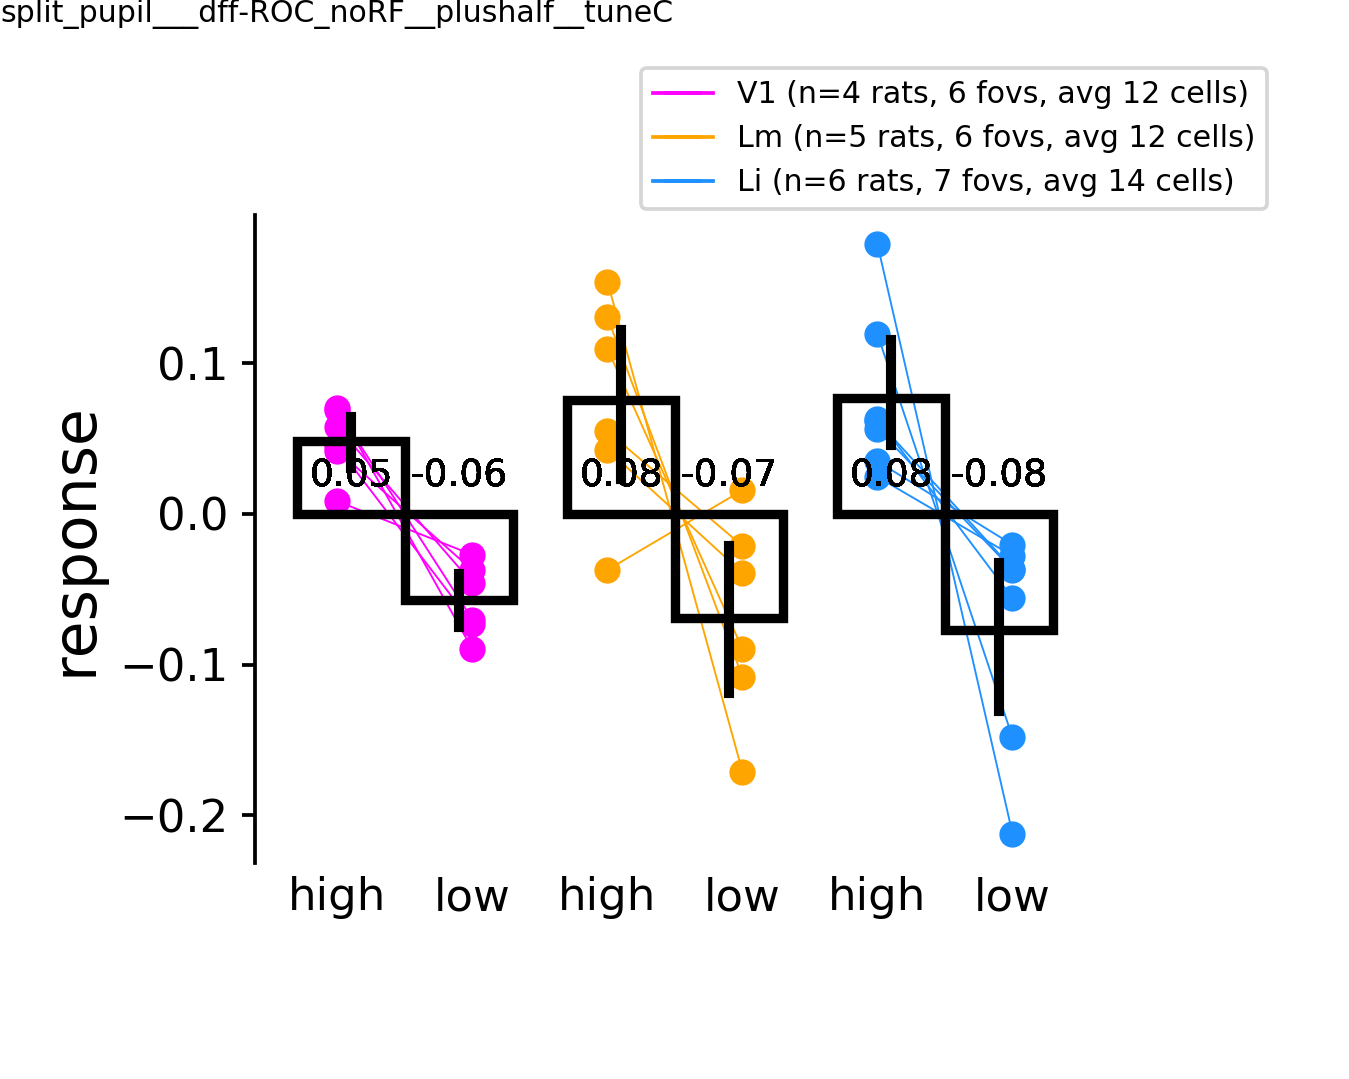

(t-stat:5.84, p=0.00)
(t-stat:2.61, p=0.05)
(t-stat:3.20, p=0.02)
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil/controls', 'mean_dff_paired_by_fov__filtered__split_pupil___dff-ROC_noRF__plushalf__tuneC')


In [82]:
c1='high'
c2='low'
compare_var='arousal'

fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
ax = aggr.plot_pairwise_by_axis(plotdf, curr_metric='response', c1=c1, c2=c2, compare_var=compare_var,
                                ax=ax, area_colors=area_colors, legend=True, bbox_to_anchor=(1.25, 1.25))
putils.label_figure(fig, data_id)
pl.subplots_adjust(left=0.2, bottom=0.2, right=0.8, top=0.8)
ax.set_xlabel('')

figname = 'mean_dff_paired_%s__filtered__%s' % (plot_str, data_id)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [255]:
plotd.head()

visual_area              datakey condition arousal         C  fit_time  \
133          V1  20190501_JC076_fov1      data    high   1.11034  0.000635   
134          V1  20190501_JC076_fov1      data     low   0.50752  0.000521   
175          V1  20190512_JC083_fov1      data    high   3.53440  0.001359   
176          V1  20190512_JC083_fov1      data     low  29.06713  0.006622   
187          V1  20190522_JC084_fov1      data    high   0.03880  0.000907   

     heldout_MI  heldout_aMI  heldout_log2MI  heldout_test_score  \
133    0.043875     0.005383        0.063298            0.580714   
134    0.024059    -0.001602        0.034710            0.589286   
175    0.014278    -0.002692        0.020599            0.498235   
176    0.028373     0.002773        0.040933            0.566500   
187    0.236671     0.312963        0.341443            0.800000   

           ...          test_score  train_score  n_cells  n_trials  iteration  \
133        ...            0.588009     0.883730     33.0      67.0       49.5   
134        ...            0.625655     0.797239     33.0      67.0       49.5   
175        ...            0.528495     0.687433     28.0      83.0       49.5   
176        ...            0.578627     0.860733     28.0      97.0       49.5   
187        ...            0.781495     0.961402    107.0      90.0       49.5   

     fraction_missing  n_missing  n_pass  feature_sample_ratio  \
133          0.333333        100     200              0.165000   
134          0.333333        100     200              0.165000   
175          0.093548         29     281              0.099644   
176          0.093548         29     281              0.099644   
187          0.030000          9     291              0.367698   

     fold_over_shuffle  
133           0.113699  
134           0.061776  
175          -0.066152  
176           0.121782  
187           0.525424  

[5 rows x 21 columns]

In [256]:
import matplotlib.ticker as ticker


In [ ]:
plotd['feature_sample_ratio'] = plotd['n_cells']/plotd['n_pass']

In [ ]:
plotd['n_cells']

In [ ]:


fig, axn = pl.subplots(1, 2, figsize=(8,4), sharex=False)
ax=axn[0]
sns.scatterplot(x='n_cells', y='fraction_missing', hue='datakey', data=plotd, ax=ax, s=100)

ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.legend_.remove()

ax=axn[1]
sns.scatterplot(x='feature_sample_ratio', y=metric, hue='datakey', data=plotd, ax=ax, s=100)
ax.legend(bbox_to_anchor=(1.1, 1))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x)))


pl.subplots_adjust(bottom=0.2, wspace=0.3, right=0.8, left=0.1)

In [ ]:
xlabels

In [ ]:
plotd[['datakey', 'arousal', 'n_trials', 'test_score', 'n_pass', 'n_cells', 'feature_sample_ratio']]

In [ ]:
fig, axn = pl.subplots(1,2)
ax=axn[0]
sns.pointplot(x='arousal', y=metric, hue='datakey', data=plotd, ax=ax)
ax.legend_.remove()


ax=axn[1]
sns.pointplot(x='arousal', y='n_cells', hue='datakey', data=plotd, ax=ax)
ax.legend_.remove()

print(plotd[plotd['n_cells']<70]['datakey'])

In [ ]:
min_ncells=5

bad_training = df[df['test_score']<0.25]['datakey'].unique()
few_cells = df[df['n_cells']<min_ncells]['datakey'].unique()

excluded = np.union1d(bad_training, few_cells)

print("Excluding %i datakeys for bad training: %s" % (len(bad_training), str(bad_training)))
print("Excluding %i datakeys for too few cells: %s" % (len(few_cells), str(few_cells)))


In [ ]:
meandf = df.groupby(['visual_area', 'datakey', 'condition', 'arousal']).mean().reset_index()
meandf[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()

In [ ]:
metric='heldout_log2MI'
plotdf = meandf[meandf['arousal'].isin(['low', 'high'])].copy()

fig, axn = pl.subplots(1,2, sharey=True)

ax=axn[0]; ax.set_title('data')
df_ = plotdf[plotdf['condition']=='data'].copy()
sns.barplot(x='visual_area', y=metric, data=df_,
              hue='arousal', dodge=True, ax=ax) #, pl.figure()

ax=axn[1]; ax.set_title('shuffled')
df_ = plotdf[plotdf['condition']=='shuffled'].copy()
sns.barplot(x='visual_area', y=metric, data=df_,
              hue='arousal', dodge=True, ax=ax) #, pl.figure()


## Check N trials per cond?

In [ ]:
ntrials_score = df.groupby(['datakey', 'arousal'])['heldout_test_score', 'n_trials'].mean().reset_index()

In [ ]:
fig, ax = pl.subplots(figsize=(4,3))

x1=ntrials_score[ntrials_score['arousal']=='high']
sns.regplot(x1['n_trials'], x1['heldout_test_score'], label='high')

x2=ntrials_score[ntrials_score['arousal']=='low']
sns.regplot(x2['n_trials'], x2['heldout_test_score'], label='low')

pl.legend()

## Check significance

In [ ]:
s_=[]
for (visual_area, datakey), d_ in df[df['arousal']=='all'].groupby(['visual_area', 'datakey']):
                            
    mean_score = d_[d_['condition']=='data'][metric].mean()
    percentile = np.mean(mean_score < d_[d_['condition']=='shuffled'][metric])
    
    s = pd.Series({'visual_area': visual_area, 'datakey': datakey, 
                   'mean_score': mean_score, 'percentile': percentile})
    s_.append(s)
    
scores = pd.concat(s_, axis=1).T

In [ ]:
visual_area='Li'
scores[scores['visual_area']==visual_area]

In [ ]:
df[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area'])['datakey'].count()


In [ ]:
area_dkeys = edata[edata['visual_area']=='V1']['datakey'].unique()
[k for k in area_dkeys if k not in df[df['visual_area']=='V1']['datakey'].unique()]
## NO cells.

In [ ]:
visual_area='Li'

plotdf = df[(df['arousal']=='all')] #& (df['visual_area']==visual_area)]

## plot
fig, axn = pl.subplots(3, 11, figsize=(10,5), sharex=True, sharey=True)
ai=0
prev_vi=0
for (visual_area, datakey), d_ in plotdf.groupby(['visual_area', 'datakey']):
    vi = visual_areas.index(visual_area)
    if prev_vi!=vi:
        ai=0
    ax = axn[vi, ai]
    if ai==0:
        ax.text(-0.3, 0.5*ai, visual_area)
        
    d_ = df[(df['arousal']=='all') & (df['datakey']==datakey) & (df['visual_area']==visual_area)]
    n_cells = d_['n_cells'].unique()[0]
    
    metric = 'heldout_test_score'
    
    sns.distplot(d_[d_['condition']=='data'][metric], ax=ax, bins=20, color='m')
    sns.distplot(d_[d_['condition']=='shuffled'][metric], ax=ax, bins=20, color='k')

    ax.set_title('%s\n(%i cells)' % (datakey, n_cells), fontsize=6, loc='left')
    #ax.axis('off')
    ai+=1
    prev_vi=vi
    
pl.subplots_adjust(left=0.05, right=0.95, wspace=0.5, hspace=0.5)

for ax in axn.flat:
    ax.axvline(x=0.5, linestyle=':', color='k')
    ax.axis('off')

## Threshold performance

In [ ]:
p_thr=0.01
pass_scores = scores[scores['percentile']<=p_thr]
pass_scores[pass_scores['visual_area']==visual_area]


In [ ]:
exclude_for_face ={'V1': ['20190510_JC083_fov1', '20190622_JC085_fov1', '20190617_JC097_fov1'],
                         #'20190507_JC083_fov1', '20190511_JC083_fov1'],
                  'Lm': ['20190506_JC080_fov1', '20190512_JC083_fov1'], 
                   'Li': []} #['20190502_JC076_fov1', '20191105_JC117_fov1', 
                          #'20190602_JC091_fov1', '20190606_JC091_fov1', '20190607_JC091_fov1'] }

#
visual_area='Li'

pass_dkeys = pass_scores[(pass_scores['visual_area']==visual_area)]['datakey'].unique()
exclude = list(meandf[~meandf['datakey'].isin(pass_dkeys)]['datakey'].unique())
exclude.extend(exclude_for_face[visual_area])

vdf = meandf[(meandf['visual_area']==visual_area) 
         & (~meandf['datakey'].isin(exclude))
         & (meandf['condition']=='data')]

xdf = vdf[vdf['arousal'].isin(['low', 'high'])] #vdf[(~vdf['datakey'].isin(skip)) & (vdf['arousal'].isin(['low','high']))]
metrics = ['heldout_log2MI', 'heldout_test_score', 'heldout_aMI']
fig, axn = pl.subplots(1, 3, figsize=(5,6), dpi=dpi)
for ai, (ax, metric) in enumerate(zip(axn.flat, metrics)):
    # Plot each fov
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=xdf, ax=ax, 
                  palette='colorblind', s=10, alpha=0.5)
    sns.barplot(x='arousal', y=metric, data=xdf, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    xdf.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -40))
    if ai<2:
        ax.legend_.remove()
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(metric, loc='left', fontsize=8)
    sns.despine(ax=ax, trim=True, offset=2)
ax.legend(bbox_to_anchor=(0, -0.3), fontsize=8)
pl.subplots_adjust(right=0.95, wspace=0.8, hspace=0.2, top=0.9, bottom=0.5, left=0.1)
fig.suptitle(visual_area)

print("STATS - %s" % visual_area)
metric = 'heldout_test_score'
for metric in metrics:
    print('%s--------------------' % metric)
    a = xdf[(xdf['arousal']=='low')][metric]
    b = xdf[(xdf['arousal']=='high')][metric]
    tstat, pval = spstats.ttest_rel(a, b)
    print("Paired t-test, t=%.2f (p=%.2f)" % (tstat, pval))

putils.label_figure(fig, data_id)

figname = 'test_metrics_%s_color-datakeys__%s' % (visual_area, data_id)
#pl.savefig(os.path.join(dst_dir, 'figures', '%s.svg' % figname))
print(figname)

In [ ]:
dst_dir

In [ ]:
os.listdir(dst_dir)


# plotting

In [239]:
v1_exclude = ['20190510_JC083_fov1', '20190511_JC083_fov1', '20190507_JC083_fov1', '20190617_JC097_fov1', '20190622_JC085_fov1']
lm_exclude=['20190506_JC080_fov1', '20190512_JC083_fov1', '20190513_JC078_fov1', '20190603_JC080_fov1']
li_exclude=['20190502_JC076_fov', '20190602_JC091_fov1', '20190606_JC091_fov1', '20190607_JC091_fov1']


exclude = [v1_exclude, lm_exclude, li_exclude, excluded]
bad_dsets = [l for sublist in exclude for l in sublist ]
len(bad_dsets)

13

<IPython.core.display.Javascript object>


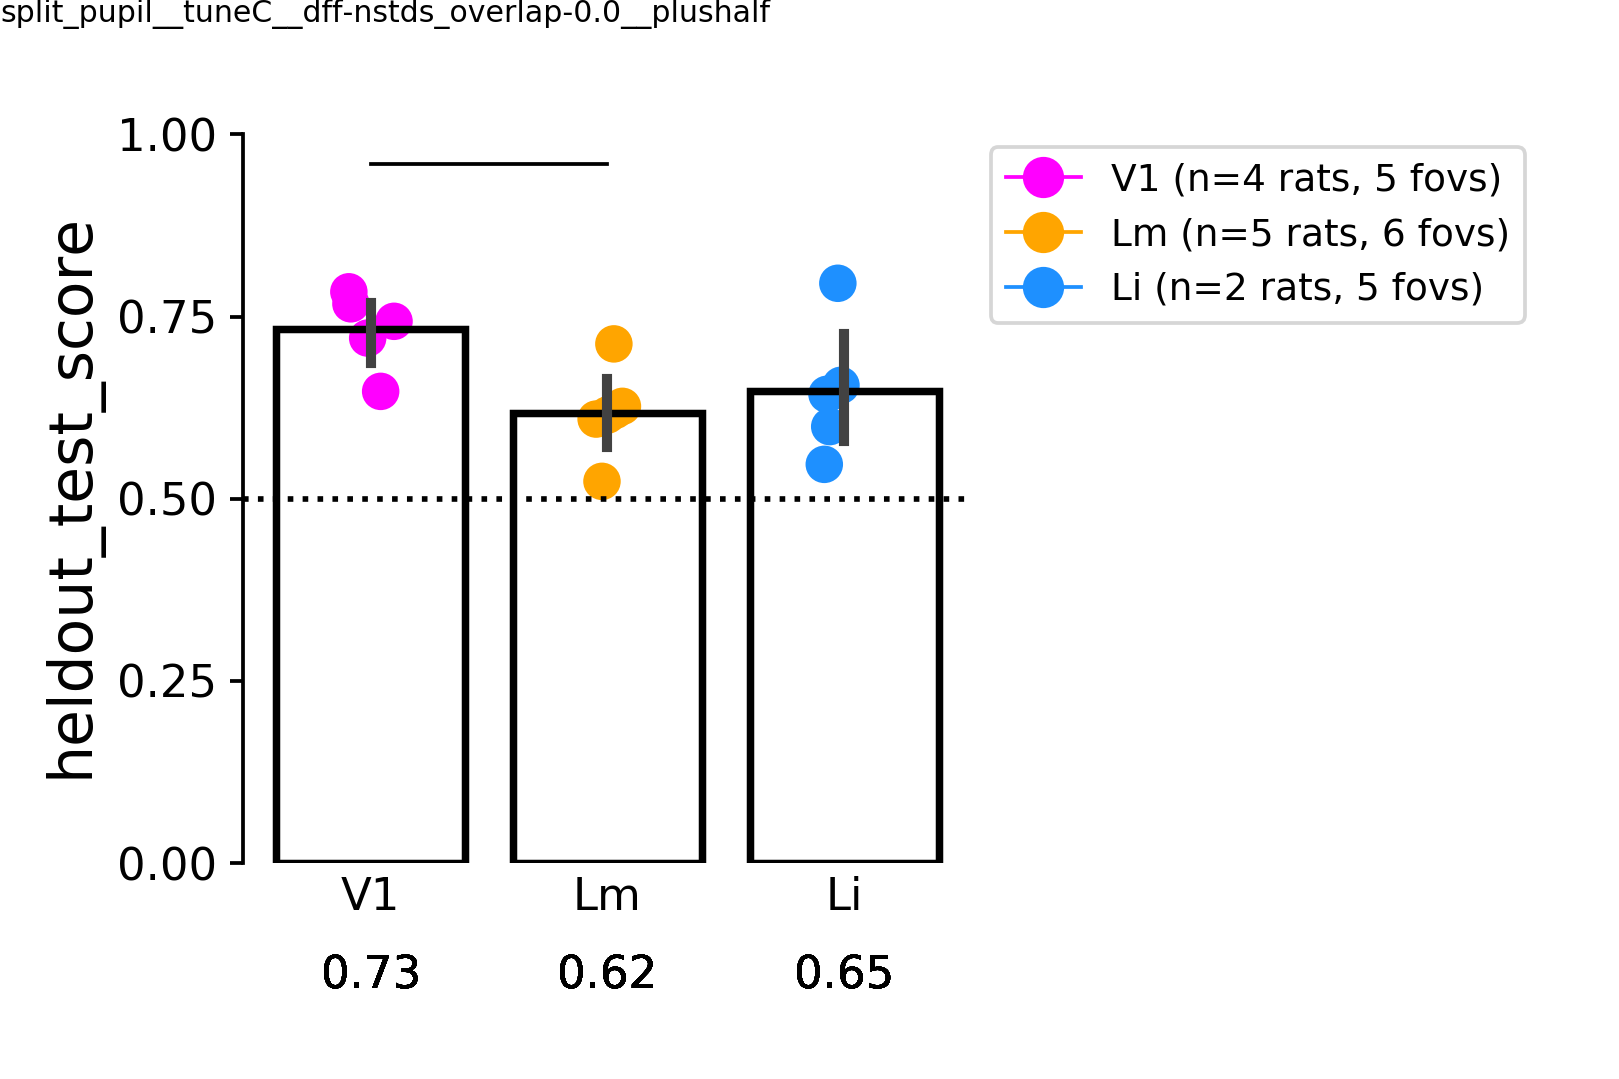

********* [heldout_test_score] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.021 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.158 (fdr_bh), reject H0=False
[('Lm', 'Li')] p=0.324 (fdr_bh), reject H0=False
****************************


In [47]:
metric = 'heldout_test_score'
#metric='heldout_log2MI'
multi_comp_test='fdr_bh'

f, ax = pl.subplots(dpi=dpi, figsize=(6,4))
f.patch.set_alpha(1)

plotdf = df[~df['datakey'].isin(exclude)].copy()


if 'pupil' in analysis_type:
    xdf = plotdf[plotdf['arousal']=='all']
else:
    xdf = plotdf.copy()

sns.barplot(x='visual_area', y=metric, data=xdf, ax=ax, order=visual_areas,
             edgecolor=('k', 'k', 'k'), facecolor='none', lw=2)

sns.stripplot(x='visual_area', y=metric, data=xdf, ax=ax,
             palette=area_colors, order=visual_areas, zorder=1, s=10)

xdf.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -30))

ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')

statsresults, ax = aggr.plot_mannwhitney(xdf, metric=metric, multi_comp_test=multi_comp_test, ax=ax)

leg = aggr.get_counts_for_legend(xdf, area_colors=area_colors, marker='o')
ax.legend(handles=leg, bbox_to_anchor=(1., 1))

if metric=='heldout_test_score':
    ax.set_yticks(np.linspace(0, 1, 5))
    sns.despine(ax=ax, trim=True)
    ax.axhline(y=0.5, ls=':', c='k')
sns.despine(bottom=True)
 
putils.label_figure(f, data_id)
pl.subplots_adjust(left=0.15, bottom=0.2, right=0.6)


# figname = 'overall_%s__%s' % (metric, data_id)
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
# print(dst_dir, figname)

<IPython.core.display.Javascript object>


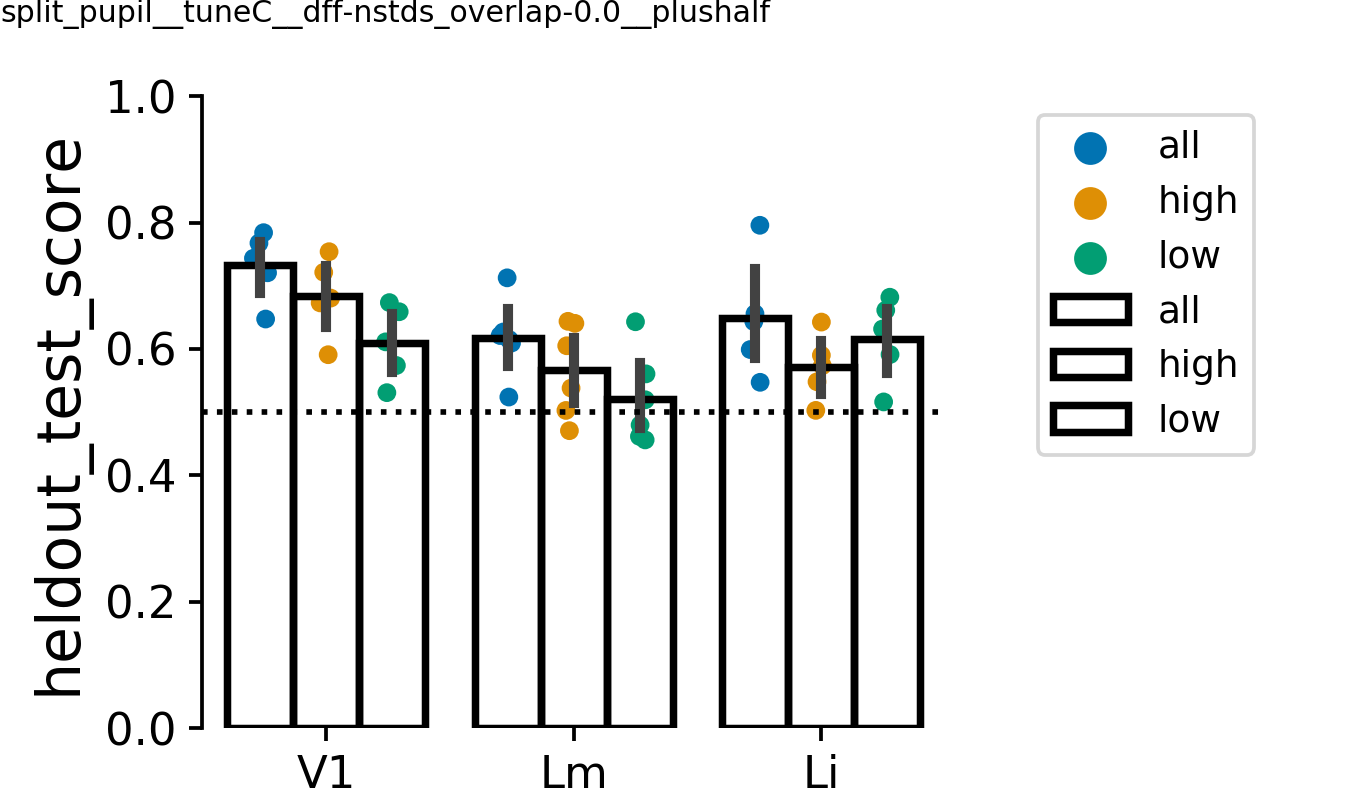

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil', 'split_low-v-high_heldout_test_score__split_pupil__tuneC__dff-nstds_overlap-0.0__plushalf')


In [48]:
if 'pupil' in analysis_type:
    metric='heldout_test_score'
    f, ax = pl.subplots(dpi=dpi, figsize=(5,3))
    f.patch.set_alpha(1)

    sns.barplot(x='visual_area', y=metric, data=plotdf, ax=ax, hue='arousal',
                order=visual_areas,
                 edgecolor=('k', 'k', 'k'), facecolor='none', lw=2)

    sns.stripplot(x='visual_area', y=metric, data=plotdf, ax=ax, hue='arousal',
                 palette='colorblind', order=visual_areas, zorder=1, s=5, dodge=True)

    sns.despine(bottom=True, ax=ax)
    ax.set_ylim([0, 1])
    ax.axhline(y=0.5, ls=':', c='k')
    ax.legend(bbox_to_anchor=(1.1, 1))

    putils.label_figure(f, data_id)
    pl.subplots_adjust(right=0.7, bottom=0.1, left=0.15)

    figname = 'split_low-v-high_%s__%s' % (metric, data_id)
    #pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    print(dst_dir, figname)

In [32]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_fov'

In [201]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.pyc'>

<IPython.core.display.Javascript object>


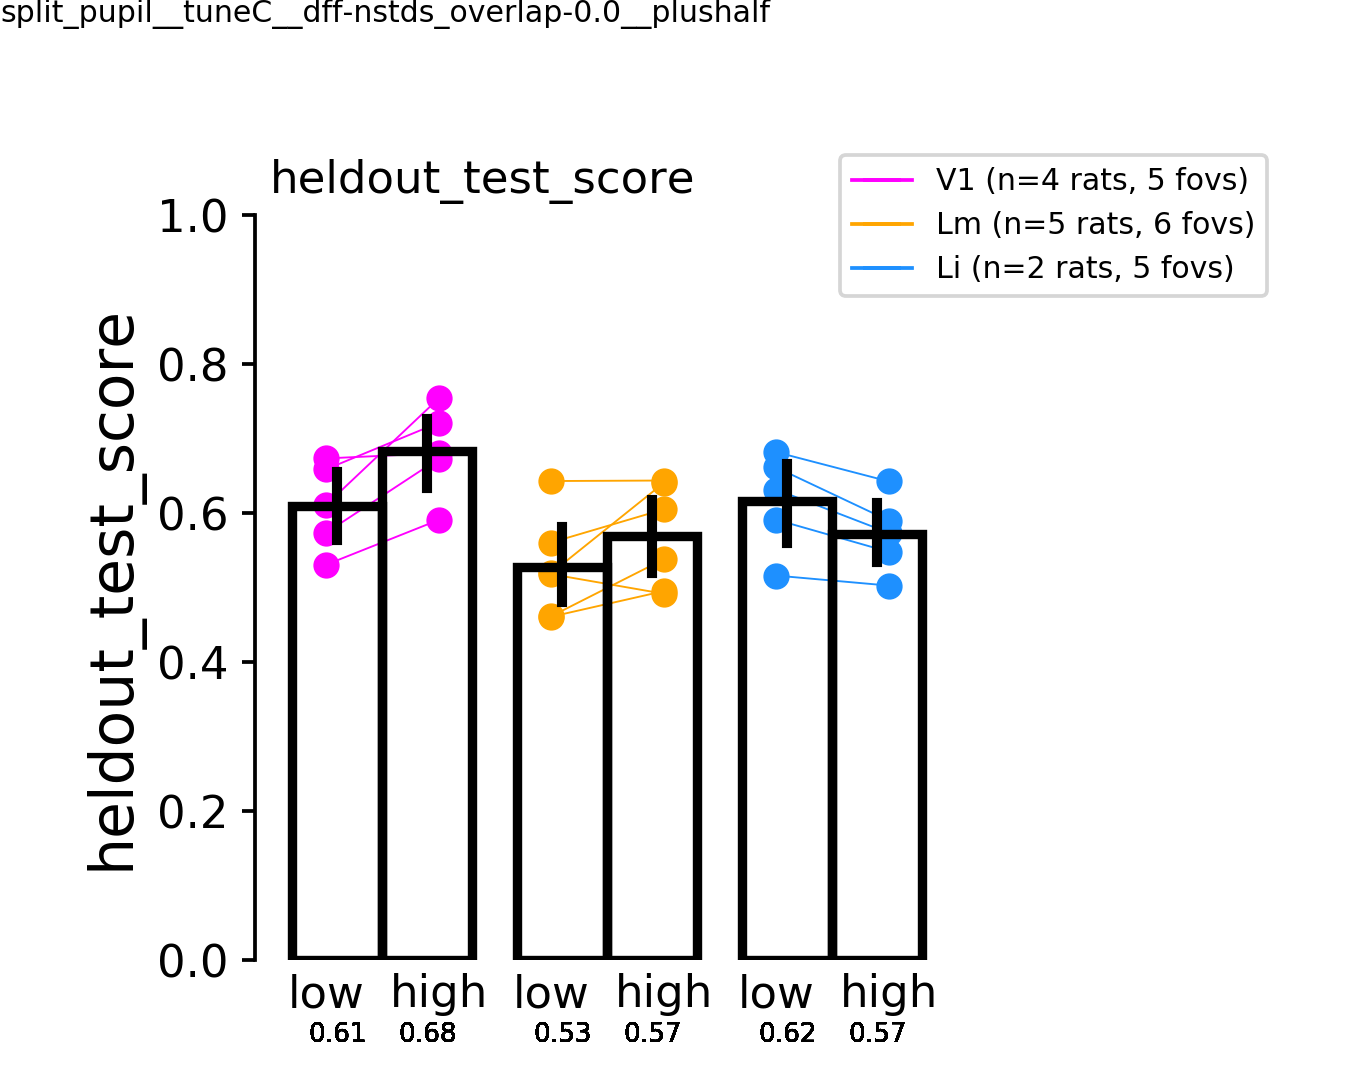

V1: (t-stat:-3.30, p=0.03)
Lm: (t-stat:-1.94, p=0.11)
Li: (t-stat:4.63, p=0.01)
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil', 'paired_low-v-high_heldout_test_score__tuneC')


<IPython.core.display.Javascript object>


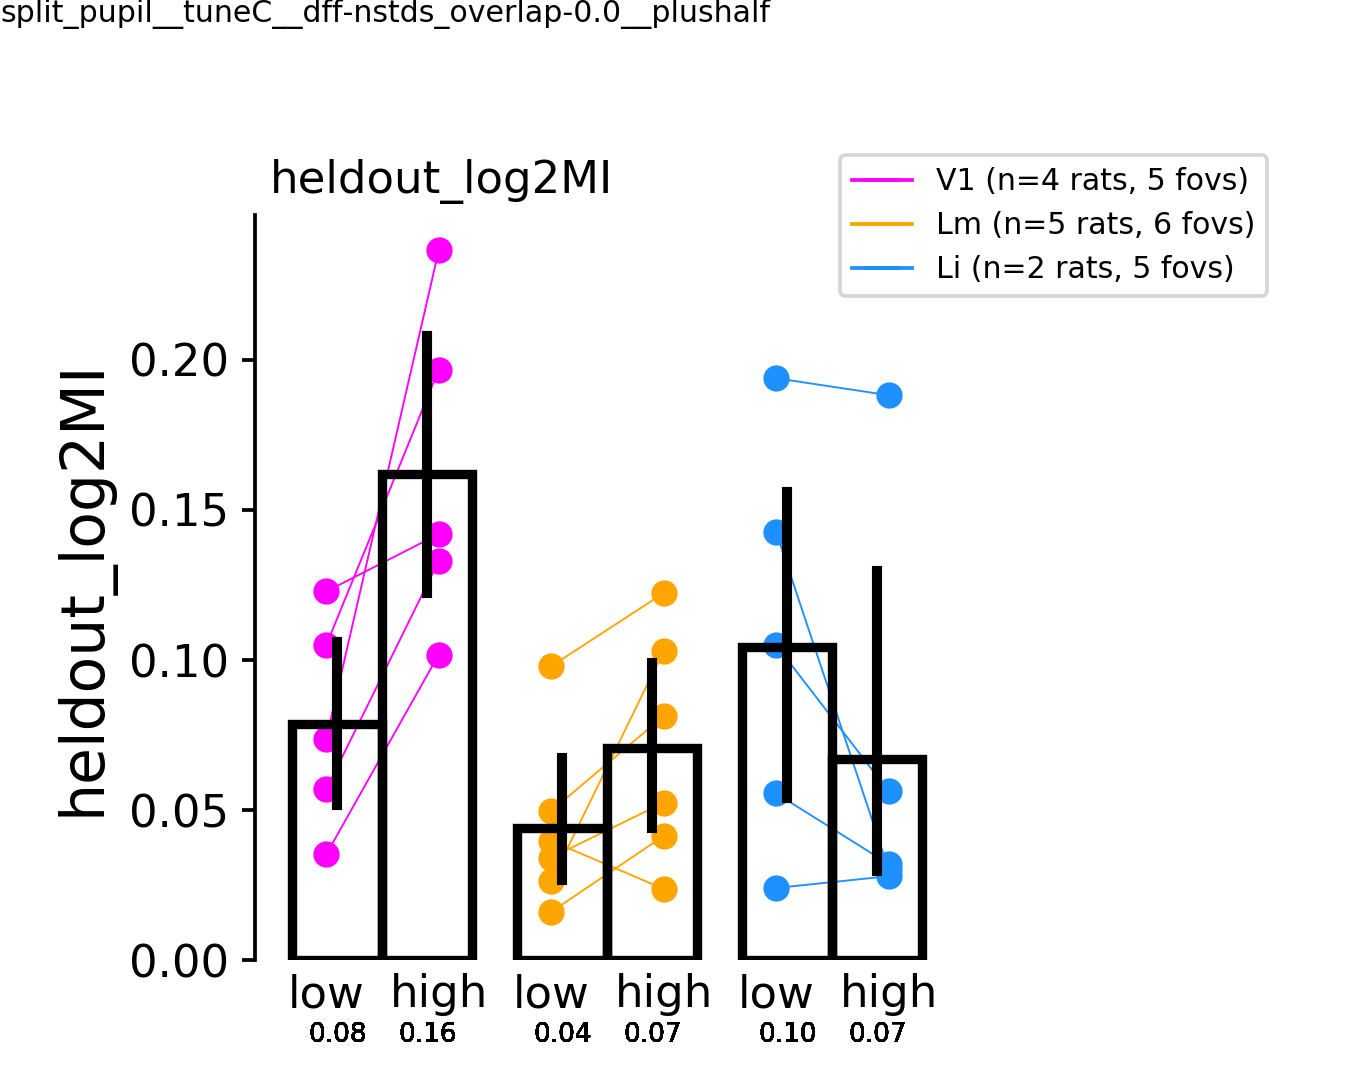

V1: (t-stat:-3.58, p=0.02)
Lm: (t-stat:-2.20, p=0.08)
Li: (t-stat:1.79, p=0.15)
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil', 'paired_low-v-high_heldout_log2MI__tuneC')


<IPython.core.display.Javascript object>


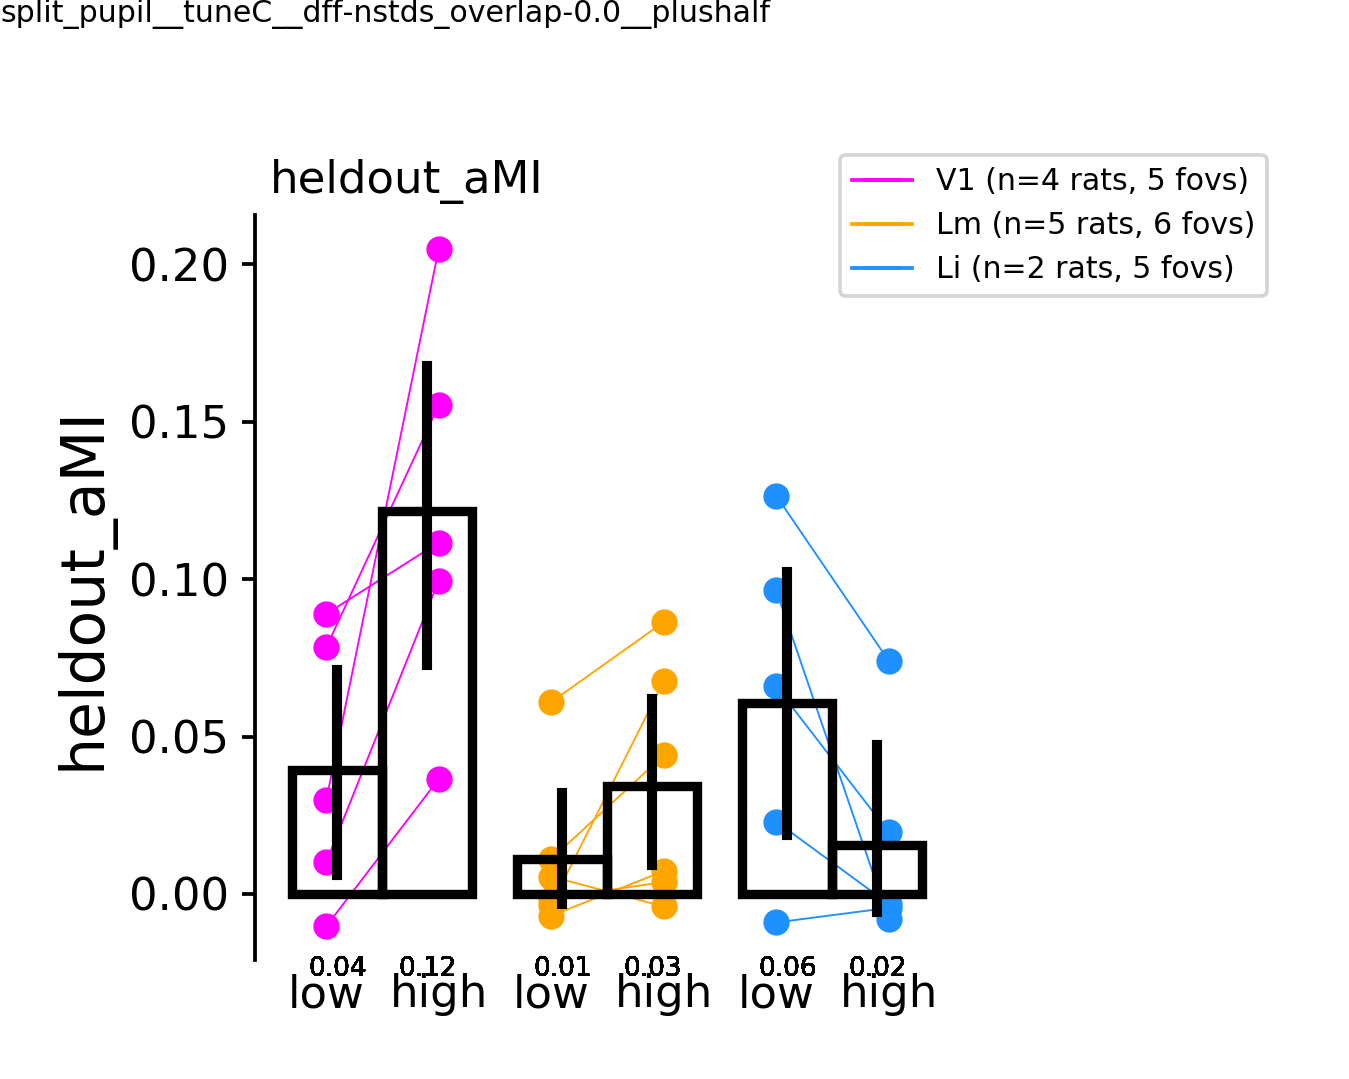

V1: (t-stat:-3.16, p=0.03)
Lm: (t-stat:-2.05, p=0.10)
Li: (t-stat:2.51, p=0.07)
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil', 'paired_low-v-high_heldout_aMI__tuneC')


<IPython.core.display.Javascript object>


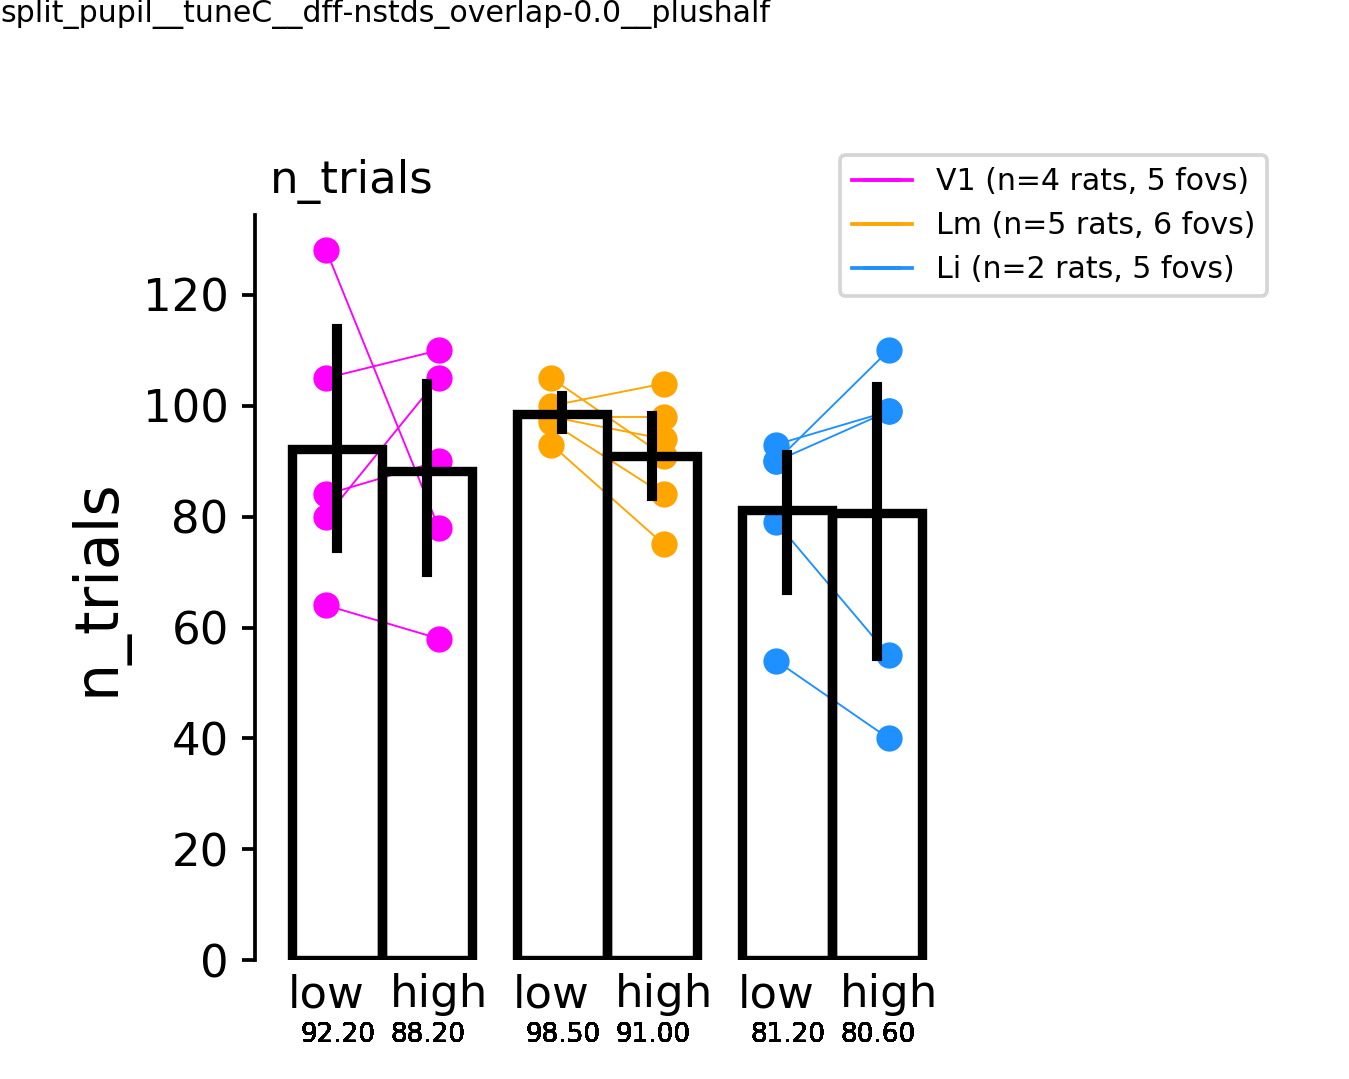

V1: (t-stat:0.32, p=0.77)
Lm: (t-stat:2.10, p=0.09)
Li: (t-stat:0.07, p=0.94)
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil', 'paired_low-v-high_n_trials__tuneC')


In [196]:
metric = 'heldout_test_score'
#metric = 'abs_coef'
plotdf = df[~df['datakey'].isin(exclude)].copy()

currdf = plotdf[(plotdf['arousal'].isin(['low', 'high'])) & (~plotdf['datakey'].isin(exclude))]


for metric in ['heldout_test_score', 'heldout_log2MI','heldout_aMI', 'n_trials']:
    fig = aggr.plot_pairwise_by_axis(currdf, curr_metric=metric, c1='low', c2='high', compare_var='arousal',
                               area_colors=area_colors, fontsize=7, fontcolor='k', fmt='%.2f', xytext=(0, -20))
    pl.subplots_adjust(left=0.2, right=0.7, top=0.8)
    fig.axes[0].set_title(metric, loc='left')
    
    if metric=='heldout_test_score':
        fig.axes[0].set_ylim([0, 1])
    putils.label_figure(fig, data_id)
    
    figname = 'paired_low-v-high_%s__%s' % (metric, C_str)
    pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    print(dst_dir, figname)

<IPython.core.display.Javascript object>


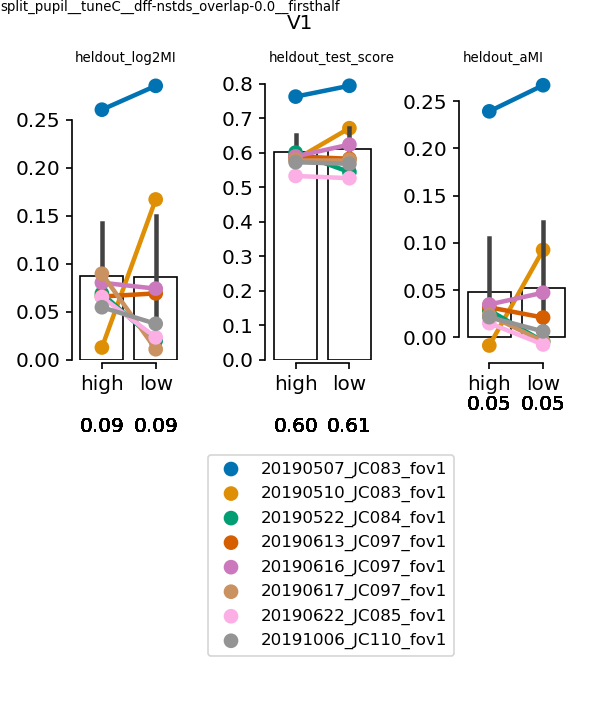

STATS - V1
heldout_log2MI--------------------
Paired t-test, t=-0.05 (p=0.96)
heldout_test_score--------------------
Paired t-test, t=0.68 (p=0.52)
heldout_aMI--------------------
Paired t-test, t=0.26 (p=0.81)
test_metrics_V1_color-datakeys__split_pupil__tuneC__dff-nstds_overlap-0.0__firsthalf


In [241]:
exclude =[] #copy.copy(v1_exclude)
#exclude=[]
visual_area='V1'

vdf = df[(df['visual_area']==visual_area) & (~df['datakey'].isin(exclude))]

xdf = vdf[vdf['arousal'].isin(['low', 'high'])] #vdf[(~vdf['datakey'].isin(skip)) & (vdf['arousal'].isin(['low','high']))]
metrics = ['heldout_log2MI', 'heldout_test_score', 'heldout_aMI']

fig, axn = pl.subplots(1, 3, figsize=(5,6), dpi=dpi)
for ai, (ax, metric) in enumerate(zip(axn.flat, metrics)):

    # Plot each fov
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=xdf, ax=ax, 
                  palette='colorblind', s=10, alpha=0.5)

    sns.barplot(x='arousal', y=metric, data=xdf, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))

    xdf.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -40))
    if ai<2:
        ax.legend_.remove()
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(metric, loc='left', fontsize=8)
    sns.despine(ax=ax, trim=True, offset=2)
ax.legend(bbox_to_anchor=(0, -0.3))
pl.subplots_adjust(right=0.95, wspace=0.8, hspace=0.2, top=0.9, bottom=0.5)
fig.suptitle(visual_area)

#
print("STATS - %s" % visual_area)
metric = 'heldout_test_score'
for metric in metrics:
    print('%s--------------------' % metric)
    a = xdf[(xdf['arousal']=='low')][metric]
    b = xdf[(xdf['arousal']=='high')][metric]
    tstat, pval = spstats.ttest_rel(a, b)
    print("Paired t-test, t=%.2f (p=%.2f)" % (tstat, pval))

putils.label_figure(fig, data_id)


figname = 'test_metrics_%s_color-datakeys__%s' % (visual_area, data_id)
#|pl.savefig(os.path.join(dst_dir, 'figures', '%s.svg' % figname))
print(figname)

<IPython.core.display.Javascript object>


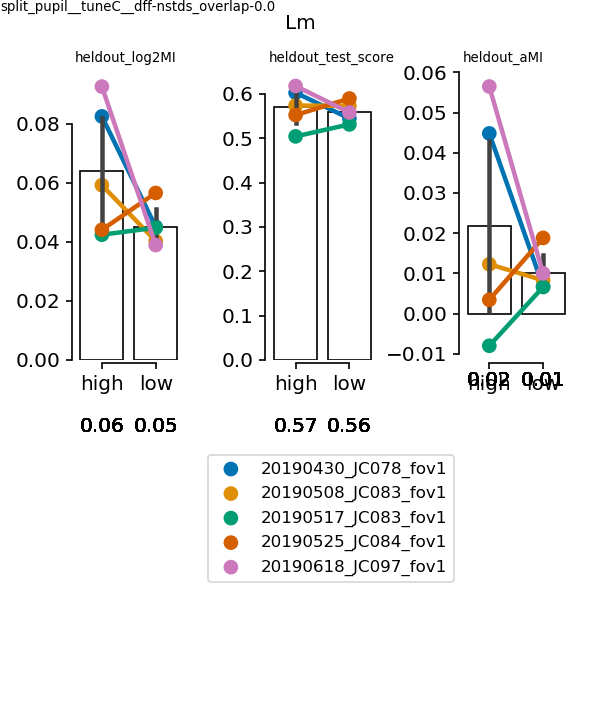

STATS - Lm
heldout_log2MI--------------------
Paired t-test, t=-1.56 (p=0.19)
heldout_test_score--------------------
Paired t-test, t=-0.52 (p=0.63)
heldout_aMI--------------------
Paired t-test, t=-0.90 (p=0.42)
test_metrics_Lm_color-datakeys__split_pupil__tuneC__dff-nstds_overlap-0.0


In [205]:
exclude=copy.copy(lm_exclude)
visual_area='Lm'
vdf = plotdf[(plotdf['visual_area']==visual_area) & (~plotdf['datakey'].isin(exclude))]

xdf = vdf[vdf['arousal'].isin(['low', 'high'])] #vdf[(~vdf['datakey'].isin(skip)) & (vdf['arousal'].isin(['low','high']))]
metrics = ['heldout_log2MI', 'heldout_test_score', 'heldout_aMI']

fig, axn = pl.subplots(1, 3, figsize=(5,6), dpi=dpi)
for ai, (ax, metric) in enumerate(zip(axn.flat, metrics)):

    # Plot each fov
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=xdf, ax=ax, 
                  palette='colorblind', s=10, alpha=0.5)

    sns.barplot(x='arousal', y=metric, data=xdf, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))

    xdf.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -40))
    if ai<2:
        ax.legend_.remove()
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(metric, loc='left', fontsize=8)
    sns.despine(ax=ax, trim=True, offset=2)
ax.legend(bbox_to_anchor=(0, -0.3))
pl.subplots_adjust(right=0.95, wspace=0.8, hspace=0.2, top=0.9, bottom=0.5)
fig.suptitle(visual_area)

#
print("STATS - %s" % visual_area)
metric = 'heldout_test_score'
for metric in metrics:
    print('%s--------------------' % metric)
    a = xdf[(xdf['arousal']=='low')][metric]
    b = xdf[(xdf['arousal']=='high')][metric]
    tstat, pval = spstats.ttest_rel(a, b)
    print("Paired t-test, t=%.2f (p=%.2f)" % (tstat, pval))

putils.label_figure(fig, data_id)

figname = 'test_metrics_%s_color-datakeys__%s' % (visual_area, data_id)
pl.savefig(os.path.join(dst_dir, 'figures', '%s.svg' % figname))
print(figname)

<IPython.core.display.Javascript object>


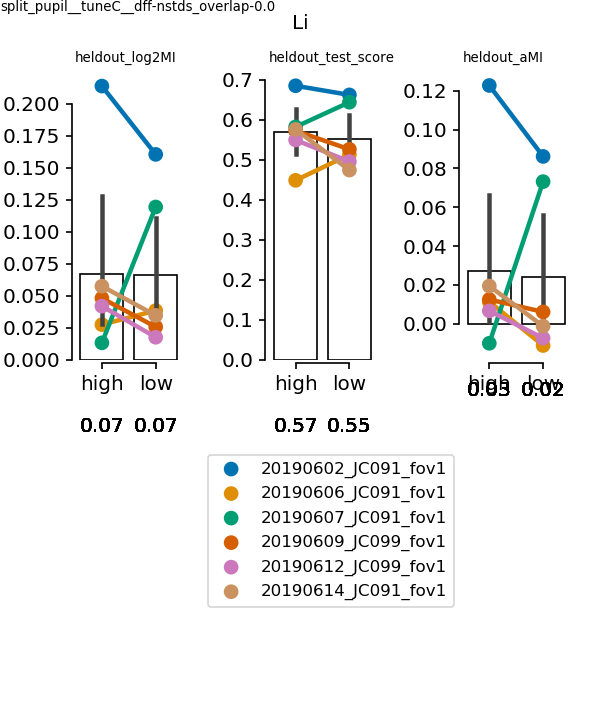

STATS - Li
heldout_log2MI--------------------
Paired t-test, t=-0.04 (p=0.97)
heldout_test_score--------------------
Paired t-test, t=-0.61 (p=0.57)
heldout_aMI--------------------
Paired t-test, t=-0.16 (p=0.88)
test_metrics_Li_color-datakeys__split_pupil__tuneC__dff-nstds_overlap-0.0


In [208]:
# exclude=['20190506_JC080_fov1', '20190512_JC083_fov1']
exclude = [] #copy.copy(li_exclude)
visual_area='Li'


#plotdf = df[~df['datakey'].isin(bad_dsets)].copy()

vdf = df[(df['visual_area']==visual_area) & (~df['datakey'].isin(exclude))]

xdf = vdf[vdf['arousal'].isin(['low', 'high'])] #vdf[(~vdf['datakey'].isin(skip)) & (vdf['arousal'].isin(['low','high']))]
metrics = ['heldout_log2MI', 'heldout_test_score', 'heldout_aMI']

fig, axn = pl.subplots(1, 3, figsize=(5,6), dpi=dpi)
for ai, (ax, metric) in enumerate(zip(axn.flat, metrics)):

    # Plot each fov
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=xdf, ax=ax, 
                  palette='colorblind', s=10, alpha=0.5)

    sns.barplot(x='arousal', y=metric, data=xdf, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))

    xdf.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -40))
    if ai<2:
        ax.legend_.remove()
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(metric, loc='left', fontsize=8)
    sns.despine(ax=ax, trim=True, offset=2)
ax.legend(bbox_to_anchor=(0, -0.3))
pl.subplots_adjust(right=0.95, wspace=0.8, hspace=0.2, top=0.9, bottom=0.5)
fig.suptitle(visual_area)

#
print("STATS - %s" % visual_area)
metric = 'heldout_test_score'
for metric in metrics:
    print('%s--------------------' % metric)
    a = xdf[(xdf['arousal']=='low')][metric]
    b = xdf[(xdf['arousal']=='high')][metric]
    tstat, pval = spstats.ttest_rel(a, b)
    print("Paired t-test, t=%.2f (p=%.2f)" % (tstat, pval))

putils.label_figure(fig, data_id)

figname = 'test_metrics_%s_color-datakeys__%s' % (visual_area, data_id)
pl.savefig(os.path.join(dst_dir, 'figures', '%s.svg' % figname))
print(figname)

In [104]:
from pipeline.python.eyetracker import dlc_utils as dlcutils

In [109]:
reload(dlcutils)

<module 'pipeline.python.eyetracker.dlc_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/eyetracker/dlc_utils.py'>

In [112]:

pupil_feature='pupil_fraction'
pupil_epoch = 'stimulus'
pupildata = dlcutils.get_aggregate_pupildfs(experiment=experiment, feature_name=pupil_feature,
                               trial_epoch=pupil_epoch, alignment_type='trial', 
                               in_rate=pupil_framerate, out_rate=pupil_framerate, 
                               iti_pre=iti_pre, iti_post=iti_post, stim_dur=stim_dur, create_new=True)


~~~~~ Aggregating pupil traces. ~~~~~~
Aggregated pupil traces. Missing 2 datasets.
20190422_JC076_fov1
20191008_JC091_fov1
~~~~~~~~~~~~ Aggregating pupil dataframes. ~~~~~~~~~~~
---> Saved aggr dataframes: /n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/metrics_blobs_pupil_fraction_stimulus_snapshot-391800.pkl


<IPython.core.display.Javascript object>


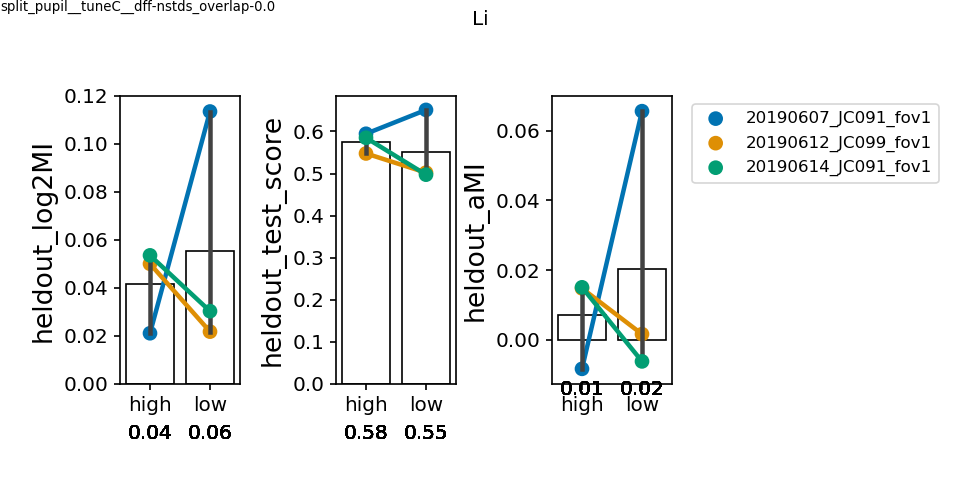

STATS - Li
heldout_log2MI--------------------
Paired t-test, t=0.35 (p=0.76)
heldout_test_score--------------------
Paired t-test, t=-0.59 (p=0.61)
heldout_aMI--------------------
Paired t-test, t=0.43 (p=0.71)


<IPython.core.display.Javascript object>


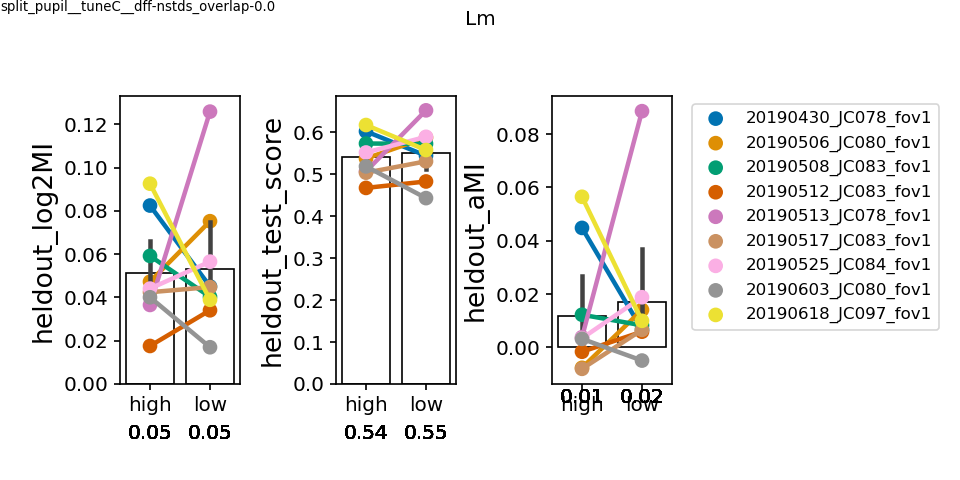

STATS - Lm
heldout_log2MI--------------------
Paired t-test, t=0.12 (p=0.91)
heldout_test_score--------------------
Paired t-test, t=0.39 (p=0.70)
heldout_aMI--------------------
Paired t-test, t=0.41 (p=0.69)


<IPython.core.display.Javascript object>


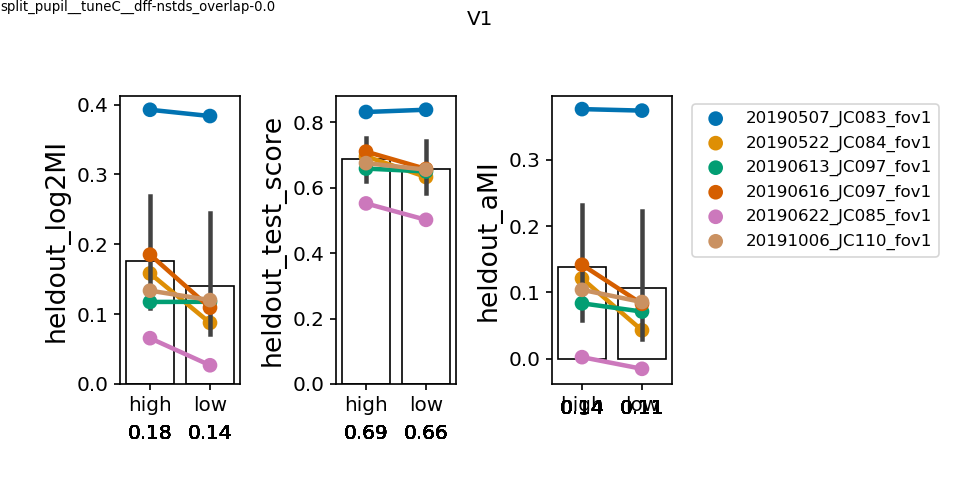

STATS - V1
heldout_log2MI--------------------
Paired t-test, t=-2.59 (p=0.05)
heldout_test_score--------------------
Paired t-test, t=-2.74 (p=0.04)
heldout_aMI--------------------
Paired t-test, t=-2.55 (p=0.05)


In [71]:

for visual_area, vdf in plotdf[~plotdf['datakey'].isin(exclude)].groupby(['visual_area']):

    xdf = vdf[vdf['arousal'].isin(['low', 'high'])] #vdf[(~vdf['datakey'].isin(skip)) & (vdf['arousal'].isin(['low','high']))]
    metrics = ['heldout_log2MI', 'heldout_test_score', 'heldout_aMI']

    fig, axn = pl.subplots(1, 3, figsize=(8,4), dpi=dpi)
    for ai, (ax, metric) in enumerate(zip(axn.flat, metrics)):

        # Plot each fov
        sns.pointplot(x='arousal', y=metric, hue='datakey', data=xdf, ax=ax, 
                      palette='colorblind', s=10, alpha=0.5)
        
        sns.barplot(x='arousal', y=metric, data=xdf, ax=ax, 
                    edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
        
        xdf.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -30))
        if ai<2:
            ax.legend_.remove()
        ax.set_xlabel('')

    ax.legend(bbox_to_anchor=(1.1, 1))
    pl.subplots_adjust(right=0.7, wspace=0.8, hspace=0.2, top=0.8, bottom=0.2)
    fig.suptitle(visual_area)
    
    #
    print("STATS - %s" % visual_area)
    metric = 'heldout_test_score'
    for metric in metrics:
        print('%s--------------------' % metric)
        a = xdf[(xdf['arousal']=='low')][metric]
        b = xdf[(xdf['arousal']=='high')][metric]
        tstat, pval = spstats.ttest_rel(a, b)
        print("Paired t-test, t=%.2f (p=%.2f)" % (tstat, pval))

    putils.label_figure(fig, data_id)
    #C_str = 'C-%.2f' % C_value if C_value is not None else 'tuneC'
    #figname = '%s_%s_morph%iv%i_%s_%i-iters' % (face_feature, visual_area, m0, m100, C_str, n_iterations)
    #pl.savefig(os.path.join(dst_dir, '%s.svg' %figname))
    #print(dst_dir, figname)

# By FOV

# Filter bad stuff

In [46]:
#### Calculate overlap with stimulus
stim_overlaps = rfutils.calculate_overlaps(RFDATA, experiment=experiment)

In [47]:
remove_too_few = True
min_ncells=0
overlap_thr=0.5

####
globalcells, cell_counts = decutils.get_pooled_cells(stim_overlaps, remove_too_few=remove_too_few,
                                                     overlap_thr=overlap_thr, min_ncells=min_ncells)


             cell
visual_area      
Li            181
Lm            299
V1            766
('V1', 766)
('Lm', 299)
('Li', 181)


In [49]:
pass_overlaps = stim_overlaps[stim_overlaps['perc_overlap']>=overlap_thr].copy()
counts_by_dset = aggr.get_counts_by_datakey(pass_overlaps)
counts_by_dset.groupby(['visual_area']).sum()

n_cells  fovnum
visual_area                 
Li               181      10
Lm               299      13
V1               766      17

In [ ]:
dst_dir


<IPython.core.display.Javascript object>


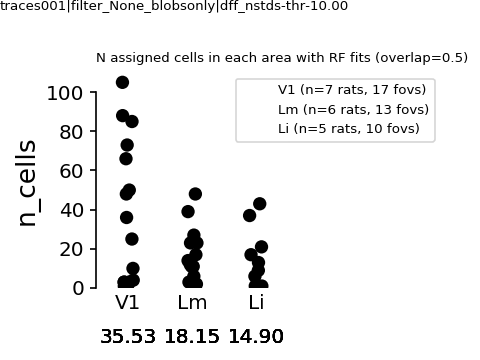

In [226]:
f, ax = pl.subplots(dpi=dpi, figsize=(4,3))
sns.stripplot(x='visual_area', y='n_cells', data=counts_by_dset, ax=ax,
             order=visual_areas, color='k', s=8, alpha=1)
sns.barplot(x='visual_area', y='n_cells', data=counts_by_dset, ax=ax,
             order=visual_areas, color='w', errcolor='w')
counts_by_dset.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -30))


ax.tick_params(which='both', axis='x', size=0)
ax.set_ylim([0, ax.get_ylim()[-1]])
sns.despine(bottom=True, trim=True, ax=ax)

ax.set_xlabel('')
pl.subplots_adjust(left=0.2, bottom=0.2, top=0.8)
ax.set_title("N assigned cells in each area with RF fits (overlap=%.1f)" % overlap_thr, loc='left', fontsize=8)
putils.label_figure(f, data_id)

leg = aggr.get_counts_for_legend(counts_by_dset, markersize=0, lw=0)
ax.legend(handles=leg, bbox_to_anchor=(1.8,1), fontsize=8)
pl.subplots_adjust(left=0.2, right=0.6, bottom=0.2)

figname = 'ncells_assigned_with_rfs__%s-%s__match-Li-distn' % (response_type, responsive_test)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))


# Decode

In [17]:

test_split=0.2
cv_nfolds=5
C_value=None

class_a=0
class_b=106


#### Test boot iter for 1 cell

In [23]:
curr_ncells = 1
gdf = globalcells[globalcells['visual_area']=='V1'].copy() # globalcells for current visual_area


In [24]:
visual_area = 'V1'

datakey = '20190613_JC097_fov1'
sdf = SDF[datakey]
gdf = globalcells[globalcells['visual_area']==visual_area].copy() # globalcells for current visual_area

rid = 2
rid in gdf['dset_roi']


True

In [25]:
curr_data = NEURALDATA[visual_area][datakey][[rid, 'config']].copy()
print(curr_data.shape)
assert len(curr_data['config'].value_counts().unique())==1, "(%s) ERR: uneven trial counts by config" % datakey


(1500, 2)


In [26]:
n_iterations=100

i_=[]; s_=[];
for inum in np.arange(0, n_iterations):
    it_df, sh_df = decutils.do_fit_within_fov(inum, curr_data=curr_data, sdf=sdf, return_shuffle=True,
                                        C_value=C_value, test_split=test_split, cv_nfolds=cv_nfolds, 
                                        class_a=class_a, class_b=class_b)
    i_.append(it_df)
    s_.append(sh_df)
    
iterdf = pd.concat(i_, axis=0)
shufdf = pd.concat(s_, axis=0)
iterdf.mean()

<IPython.core.display.Javascript object>


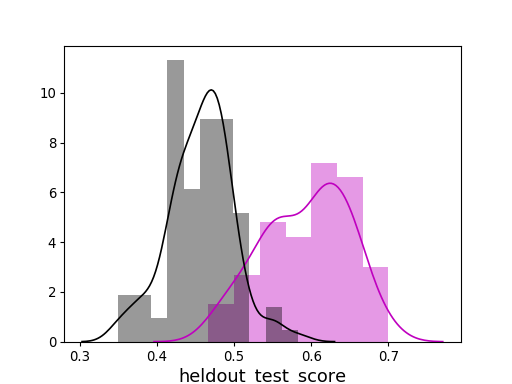

In [29]:
metric='heldout_test_score'
ci=0.95

f, ax = pl.subplots()
sns.distplot(iterdf[metric], color='m')
sns.distplot(shufdf[metric], color='k')

# ci_lo, ci_hi = putils.get_empirical_ci(iterdf[metric].values, ci=ci)
# ax.axvline(x=ci_lo, linestyle=':', c='k')
# ax.axvline(x=ci_hi, linestyle=':', c='k')

In [8]:
def load_cell_results_from_fov(animalid, session, fov, experiment, traceid='traces001',
                               C_value=None, response_type='dff', responsive_test='nstds',
                              rootdir='/n/coxfs01/2p-data'):
    '''
    From running batch, slurm/decode_by_ncells.py (Set analysis_type='single_cells'),
    load all the cells' results.
    '''
    roidf=None
    sub_dir = '%s-%s' % (response_type, responsive_test)
    #print(sub_dir)
    C_str = 'tuneC' if C_value is None else 'C-%.2f' % C_value
    cell_results = glob.glob(os.path.join(rootdir, animalid, session, fov, 
                            'combined_%s_static' % experiment, 'traces', '%s*' % traceid, 
                            'decoding', 'single_cells', sub_dir, '*%s*.pkl' % C_str))

    #print("... %i cell results" % len(cell_results))

    rlist=[]
    for c in cell_results:
        with open(c, 'rb') as f:
            r_ = pkl.load(f)
        means_ = r_.mean()
        non_num = [i for i in r_.columns if i not in means_.index]
        #metainfo = dict((k, r_[k].unique()[0]) for k in non_num)
        for k in non_num:
            means_[k] = r_[k].unique()[0]
        means_ = pd.to_numeric(r_.mean())

        rlist.append(means_)
        
    if len(rlist)>0:
        roidf = pd.concat(rlist, axis=1).T
    
    return roidf


In [ ]:
# INFO:  [7763640]: 20190507_JC083_fov1_V1_tuneC
# INFO:  [7763651]: 20190522_JC084_fov1_V1_tuneC   
        
# INFO:  [7763654]: 20190613_JC097_fov1_V1_tuneC 
# INFO:  [7763657]: 20190616_JC097_fov1_V1_tuneC 
# INFO:  [7763659]: 20190617_JC097_fov1_V1_tuneC
# INFO:  [7763661]: 20190622_JC085_fov1_V1_tuneC
# INFO:  [7763664]: 20191006_JC110_fov1_V1_tuneC

In [9]:
rootdir='/n/coxfs01/2p-data'
traceid='traces001'
experiment='blobs'
# -----------------------------------------------------
response_type='dff'
responsive_test='nstds'
# -----------------------------------------------------


In [ ]:
visual_area = 'Li'
animalid = 'JC091'
session = '20190614'
fovnum = 1
fov = 'FOV%i_zoom2p0x' % fovnum
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)

# curr_ncells = globalcells[(globalcells['datakey']==datakey) & (globalcells['visual_area']==visual_area)].shape
roidf = load_cell_results_from_fov(animalid, session, fov, experiment, traceid=traceid,
                                   C_value=None, response_type=response_type, responsive_test=responsive_test,
                                   rootdir=rootdir)
curr_ncells = roidf.shape[0]
metainfo = {'datakey': datakey, 'visual_area': visual_area}
roidf = putils.add_meta_to_df(roidf, metainfo)


In [20]:
print(roidf.shape)
sub_dir = '%s-%s' % (response_type, responsive_test)
print(sub_dir)
C_str = 'tuneC' if C_value is None else 'C-%.2f' % C_value
cell_results = glob.glob(os.path.join(rootdir, animalid, session, fov, 
                        'combined_%s_static' % experiment, 'traces', '%s*' % traceid, 
                        'decoding', 'single_cells', sub_dir, '*%s*.pkl' % C_str))
print(len(cell_results))

(37, 14)
dff-nstds
37


<IPython.core.display.Javascript object>


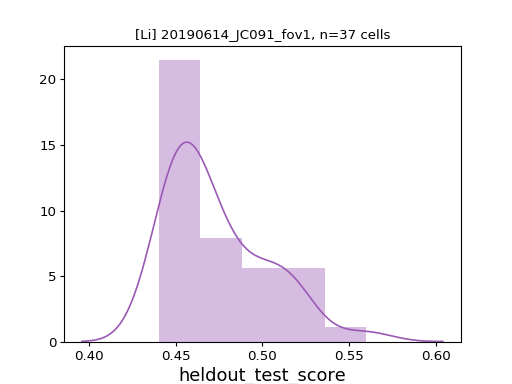

Text(0.5,1,u'[Li] 20190614_JC091_fov1, n=37 cells')

In [21]:
fig, ax = pl.subplots()
sns.distplot(roidf['heldout_test_score'], ax=ax)
ax.set_title("[%s] %s, n=%i cells" % (visual_area, datakey, curr_ncells))



In [10]:
r_list=[]
for (visual_area, animalid, session, fovnum, datakey), g in globalcells.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'datakey']):
    roidf = load_cell_results_from_fov(animalid, session, 'FOV%i_zoom2p0x' % fovnum, experiment, traceid=traceid,rootdir=rootdir)
    if roidf is None:
        print("[%s] %s - No cells." % (visual_area, datakey))
        continue
    curr_ncells = roidf.shape[0]
    print("[%s] %s, n=%i cells" % (visual_area, datakey, curr_ncells))
    metainfo = {'datakey': datakey, 'visual_area': visual_area}
    roidf = putils.add_meta_to_df(roidf, metainfo)
    r_list.append(roidf)
singledf = pd.concat(r_list, axis=0)

NameError: name 'globalcells' is not defined

In [ ]:
INFO:  [7985264]: 20190430_JC078_fov1_Lm_tuneC
INFO:  [7985267]: 20190506_JC080_fov1_Lm_tuneC
INFO:  [7985271]: 20190513_JC078_fov1_Lm_tuneC
INFO:  [7985273]: 20190525_JC084_fov1_Lm_tuneC
INFO:  [7985276]: 20190618_JC097_fov1_Lm_tuneC
INFO:  [7985274]: 20190603_JC080_fov1_Lm_tuneC
        
INFO:  [7985265]: 20190504_JC078_fov1_Lm_tuneC
INFO:  [7985268]: 20190508_JC083_fov1_Lm_tuneC
INFO:  [7985269]: 20190509_JC078_fov1_Lm_tuneC
INFO:  [7985270]: 20190512_JC083_fov1_Lm_tuneC
INFO:  [7985272]: 20190517_JC083_fov1_Lm_tuneC
INFO:  [7985277]: 20190627_JC091_fov1_Lm_tune


In [47]:
min_ncells=60
curr_dkeys = [k for k, g in singledf.groupby(['datakey']) if len(g)<min_ncells]

<IPython.core.display.Javascript object>


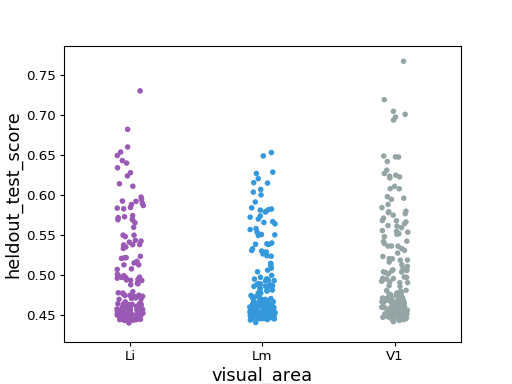

In [49]:
metric='heldout_test_score'

fig, ax = pl.subplots()
sns.stripplot(x='visual_area', y=metric, data=singledf[singledf['datakey'].isin(curr_dkeys)], ax=ax)

In [28]:
singledf.groupby(['visual_area']).mean()

C  fit_time  heldout_MI  heldout_aMI  heldout_log2MI  \
visual_area                                                                
Li           8.390145  0.001162    0.011191     0.008852        0.016145   
Lm           7.421948  0.001123    0.008848     0.005680        0.012765   
V1           7.736929  0.001147    0.012561     0.010258        0.018121   

             heldout_test_score  n_cells    n_trials  score_time  test_score  \
visual_area                                                                    
Li                     0.498520      1.0  296.392405    0.000312    0.540805   
Lm                     0.488769      1.0  296.011236    0.000319    0.533930   
V1                     0.508667      1.0  303.130755    0.000292    0.546073   

             train_score        cell  
visual_area                           
Li              0.545417  152.436709  
Lm              0.538750  116.831461  
V1              0.550571  107.425414

<IPython.core.display.Javascript object>


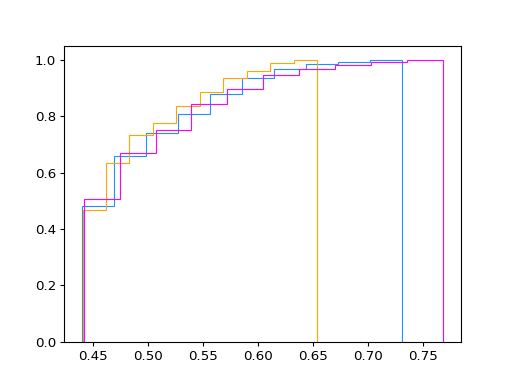

In [51]:
metric='heldout_test_score'
fig, ax = pl.subplots()
# for visual_area, vdf in singledf.groupby(['visual_area']):
#     sns.distplot(vdf[metric].values, color=area_colors[visual_area], ax=ax, kde=False, #bins=100,
#                 hist_kws={"histtype": "step", "linewidth": 3})

xdf = singledf[singledf['datakey'].isin(curr_dkeys)]
for visual_area, vdf in xdf.groupby(['visual_area']):
    n, bins, patches = ax.hist(vdf[metric].values, color=area_colors[visual_area],
                                density=True, histtype='step', cumulative=True)
    
    
